In [1]:
!pip install -q torchsummary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import OneCycleLR
import time

In [2]:
# KANLinear class definition as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy



## Kode versi terbaru ini ditambahkan batch_normalisasi pada setiap akhir layer conv

1. Stabilisasi Distribusi Aktivasi:

Batch Normalization menstabilkan distribusi aktivasi jaringan dengan menormalkan output dari setiap layer berdasarkan mini-batch.
Ini membantu mengurangi masalah "vanishing gradients" (gradien menghilang) dan "exploding gradients" (gradien meledak), yang sering menjadi kendala dalam pelatihan jaringan yang dalam.

2. Akselerasi Konvergensi:

Dengan menormalkan input di setiap lapisan, model dapat menggunakan tingkat pembelajaran yang lebih tinggi tanpa takut terjebak dalam lokal minima atau divergen.
Hal ini mempercepat proses pelatihan karena model lebih cepat menemukan optimal point.

3. Regularisasi Implisit:

Batch Normalization menambahkan sedikit noise pada setiap mini-batch selama pelatihan, yang bertindak sebagai regularizer dan membantu mencegah overfitting.
Ini membuat model lebih generalizable ke data yang belum pernah dilihat sebelumnya.

4. Mengurangi Ketergantungan pada Inisialisasi Parameter:

Model menjadi lebih robust terhadap inisialisasi parameter yang buruk karena Batch Normalization mengontrol skala aktivasi.
Ini memungkinkan penggunaan berbagai skema inisialisasi tanpa kehilangan performa.

5. Mengurangi Sensitivitas terhadap Skala Input:

Dengan menormalkan data dalam mini-batch, Batch Normalization mengurangi sensitivitas model terhadap skala dan distribusi input awal.
Ini membantu dalam situasi di mana data memiliki berbagai macam skala dan distribusi.

In [3]:
class KANVGG19(nn.Module):
    def __init__(self, num_classes=100):  # Default is for ImageNet
        super(KANVGG19, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
        )
        self.classifier = nn.Sequential(
            KANLinear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            KANLinear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            KANLinear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

KANVGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(i

100%|██████████| 169001437/169001437 [00:04<00:00, 40342597.59it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Train Epoch: 0 [0/50000 (0%)]	Loss: 4.600753
Train Epoch: 0 [640/50000 (2%)]	Loss: 4.622760
Train Epoch: 0 [1280/50000 (3%)]	Loss: 4.616072
Train Epoch: 0 [1920/50000 (5%)]	Loss: 4.606575
Train Epoch: 0 [2560/50000 (6%)]	Loss: 4.593215
Train Epoch: 0 [3200/50000 (8%)]	Loss: 4.537994
Train Epoch: 0 [3840/50000 (10%)]	Loss: 4.591416
Train Epoch: 0 [4480/50000 (11%)]	Loss: 4.490096
Train Epoch: 0 [5120/50000 (13%)]	Loss: 4.521151
Train Epoch: 0 [5760/50000 (14%)]	Loss: 4.504742
Train Epoch: 0 [6400/50000 (16%)]	Loss: 4.583402
Train Epoch: 0 [7040/50000 (18%)]	Loss: 4.459148
Train Epoch: 0 [7680/50000 (19%)]	Loss: 4.450318
Train Epoch: 0 [8320/50000 (21%)]	Loss: 4.617778
Train Epoch: 0 [8960/50000 (22%)]	Loss: 4.476145
Train Epoch: 0 [9600/50000 (24%)]	Loss: 4.387086
Train Epoch: 0 [10240/50000 (26%)]	Loss: 4.449265
Train Epoch: 0 [10880/50000 (27%)]	Loss: 4.420549
Train Epoch: 0 [11520/50000 (29%)]	L

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.20      0.12      0.15       100
           1       0.00      0.00      0.00       100
           2       0.03      0.01      0.01       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.04      0.02      0.03       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.17      0.03      0.05       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.00      0.00      0.00       100
          13       0.00      0.00      0.00       100
          14       0.11      0.02      0.03       100
          15       0.00      0.00      0.00       100
          16       0.00      0.00      0.00       100
          17       0.04    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.14      0.20      0.17       100
           1       0.17      0.01      0.02       100
           2       0.00      0.00      0.00       100
           3       0.02      0.08      0.04       100
           4       0.00      0.00      0.00       100
           5       0.01      0.01      0.01       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.06      0.04      0.05       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.00      0.00      0.00       100
          13       0.04      0.06      0.05       100
          14       0.07      0.25      0.10       100
          15       0.00      0.00      0.00       100
          16       0.00      0.00      0.00       100
          17       0.10    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.19      0.30      0.23       100
           1       0.00      0.00      0.00       100
           2       0.08      0.07      0.08       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.05      0.09      0.06       100
           6       0.07      0.01      0.02       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00       100
          11       0.03      0.01      0.02       100
          12       0.05      0.06      0.06       100
          13       0.06      0.10      0.07       100
          14       0.08      0.17      0.10       100
          15       0.00      0.00      0.00       100
          16       0.00      0.00      0.00       100
          17       0.08    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.24      0.34      0.28       100
           1       0.04      0.03      0.03       100
           2       0.10      0.24      0.14       100
           3       0.07      0.01      0.02       100
           4       0.00      0.00      0.00       100
           5       0.02      0.05      0.03       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.12      0.04      0.06       100
           9       0.07      0.02      0.03       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.09      0.30      0.14       100
          13       0.50      0.01      0.02       100
          14       0.07      0.24      0.11       100
          15       0.11      0.02      0.03       100
          16       0.07      0.04      0.05       100
          17       0.20    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.29      0.19      0.23       100
           1       0.04      0.10      0.06       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.05      0.04      0.04       100
           6       0.05      0.01      0.02       100
           7       0.00      0.00      0.00       100
           8       0.07      0.23      0.11       100
           9       0.33      0.04      0.07       100
          10       0.00      0.00      0.00       100
          11       0.14      0.03      0.05       100
          12       0.18      0.08      0.11       100
          13       0.08      0.07      0.08       100
          14       0.13      0.11      0.12       100
          15       0.04      0.07      0.05       100
          16       0.07      0.12      0.09       100
          17       0.26    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.31      0.35      0.33       100
           1       0.09      0.28      0.13       100
           2       0.00      0.00      0.00       100
           3       0.06      0.11      0.07       100
           4       0.00      0.00      0.00       100
           5       0.07      0.11      0.08       100
           6       1.00      0.01      0.02       100
           7       0.00      0.00      0.00       100
           8       0.16      0.13      0.14       100
           9       0.20      0.04      0.07       100
          10       0.00      0.00      0.00       100
          11       0.10      0.11      0.11       100
          12       0.11      0.16      0.13       100
          13       0.18      0.05      0.08       100
          14       0.15      0.08      0.10       100
          15       0.07      0.10      0.08       100
          16       0.08      0.10      0.09       100
          17       0.31    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.42      0.24      0.31       100
           1       0.09      0.29      0.14       100
           2       0.00      0.00      0.00       100
           3       0.06      0.03      0.04       100
           4       0.00      0.00      0.00       100
           5       0.08      0.08      0.08       100
           6       0.14      0.12      0.13       100
           7       0.00      0.00      0.00       100
           8       0.24      0.08      0.12       100
           9       0.25      0.01      0.02       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.13      0.19      0.16       100
          13       0.13      0.22      0.16       100
          14       0.10      0.10      0.10       100
          15       0.08      0.10      0.09       100
          16       0.15      0.07      0.10       100
          17       0.20    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.19      0.52      0.28       100
           1       0.07      0.14      0.09       100
           2       0.40      0.02      0.04       100
           3       0.00      0.00      0.00       100
           4       0.11      0.04      0.06       100
           5       0.04      0.11      0.06       100
           6       0.25      0.03      0.05       100
           7       0.00      0.00      0.00       100
           8       0.24      0.12      0.16       100
           9       0.18      0.12      0.15       100
          10       0.50      0.01      0.02       100
          11       0.14      0.23      0.17       100
          12       0.11      0.10      0.11       100
          13       0.19      0.20      0.20       100
          14       0.20      0.07      0.10       100
          15       0.08      0.14      0.10       100
          16       0.07      0.02      0.03       100
          17       0.21    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.40      0.27      0.32       100
           1       0.09      0.14      0.11       100
           2       0.10      0.09      0.09       100
           3       0.06      0.03      0.04       100
           4       0.00      0.00      0.00       100
           5       0.02      0.01      0.01       100
           6       0.17      0.09      0.12       100
           7       0.00      0.00      0.00       100
           8       0.31      0.25      0.28       100
           9       0.27      0.13      0.18       100
          10       0.00      0.00      0.00       100
          11       0.23      0.17      0.20       100
          12       0.19      0.18      0.18       100
          13       0.16      0.15      0.15       100
          14       0.19      0.11      0.14       100
          15       0.08      0.10      0.09       100
          16       0.15      0.05      0.07       100
          17       0.30    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.28      0.52      0.36       100
           1       0.12      0.53      0.20       100
           2       0.17      0.14      0.15       100
           3       0.11      0.03      0.05       100
           4       0.07      0.09      0.08       100
           5       0.05      0.08      0.06       100
           6       0.22      0.08      0.12       100
           7       0.00      0.00      0.00       100
           8       0.24      0.26      0.25       100
           9       0.13      0.28      0.17       100
          10       0.00      0.00      0.00       100
          11       0.19      0.13      0.15       100
          12       0.16      0.15      0.16       100
          13       0.17      0.20      0.18       100
          14       0.19      0.12      0.15       100
          15       0.10      0.15      0.12       100
          16       0.15      0.12      0.13       100
          17       0.19    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.40      0.54      0.46       100
           1       0.12      0.36      0.18       100
           2       0.19      0.07      0.10       100
           3       0.09      0.07      0.08       100
           4       0.04      0.04      0.04       100
           5       0.10      0.14      0.12       100
           6       0.17      0.07      0.10       100
           7       0.00      0.00      0.00       100
           8       0.24      0.16      0.19       100
           9       0.29      0.21      0.24       100
          10       0.10      0.02      0.03       100
          11       0.27      0.08      0.12       100
          12       0.26      0.17      0.21       100
          13       0.09      0.03      0.04       100
          14       0.13      0.16      0.14       100
          15       0.07      0.23      0.11       100
          16       0.25      0.13      0.17       100
          17       0.37    

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 12 [0/50000 (0%)]	Loss: 3.130094
Train Epoch: 12 [640/50000 (2%)]	Loss: 3.058221
Train Epoch: 12 [1280/50000 (3%)]	Loss: 3.070675
Train Epoch: 12 [1920/50000 (5%)]	Loss: 3.179117
Train Epoch: 12 [2560/50000 (6%)]	Loss: 3.323832
Train Epoch: 12 [3200/50000 (8%)]	Loss: 3.239705
Train Epoch: 12 [3840/50000 (10%)]	Loss: 3.241248
Train Epoch: 12 [4480/50000 (11%)]	Loss: 2.962195
Train Epoch: 12 [5120/50000 (13%)]	Loss: 3.370221
Train Epoch: 12 [5760/50000 (14%)]	Loss: 3.471096
Train Epoch: 12 [6400/50000 (16%)]	Loss: 3.080537
Train Epoch: 12 [7040/50000 (18%)]	Loss: 3.597601
Train Epoch: 12 [7680/50000 (19%)]	Loss: 3.148836
Train Epoch: 12 [8320/50000 (21%)]	Loss: 3.164431
Train Epoch: 12 [8960/50000 (22%)]	Loss: 2.944525
Train Epoch: 12 [9600/50000 (24%)]	Loss: 3.302062
Train Epoch: 12 [10240/50000 (26%)]	Loss: 3.215412
Train Epoch: 12 [10880/50000 (27%)]	Loss: 3.627861
Train Epoch: 12 [11520/50000 (29%)]	Loss: 3.156816
Train Epoch: 12 [12160/50000 (30%)]	Loss: 3.237702
Train 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.49      0.31      0.38       100
           1       0.17      0.40      0.24       100
           2       0.19      0.20      0.19       100
           3       0.15      0.14      0.14       100
           4       0.16      0.03      0.05       100
           5       0.10      0.10      0.10       100
           6       0.21      0.29      0.25       100
           7       0.31      0.12      0.17       100
           8       0.26      0.23      0.25       100
           9       0.26      0.25      0.25       100
          10       0.00      0.00      0.00       100
          11       0.19      0.06      0.09       100
          12       0.33      0.23      0.27       100
          13       0.13      0.09      0.11       100
          14       0.19      0.28      0.23       100
          15       0.15      0.08      0.10       100
          16       0.23      0.22      0.23       100
          17       0.47    

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 14 [0/50000 (0%)]	Loss: 2.935547
Train Epoch: 14 [640/50000 (2%)]	Loss: 3.242110
Train Epoch: 14 [1280/50000 (3%)]	Loss: 3.074280
Train Epoch: 14 [1920/50000 (5%)]	Loss: 3.041308
Train Epoch: 14 [2560/50000 (6%)]	Loss: 2.964357
Train Epoch: 14 [3200/50000 (8%)]	Loss: 3.256492
Train Epoch: 14 [3840/50000 (10%)]	Loss: 3.038986
Train Epoch: 14 [4480/50000 (11%)]	Loss: 3.179635
Train Epoch: 14 [5120/50000 (13%)]	Loss: 3.045773
Train Epoch: 14 [5760/50000 (14%)]	Loss: 3.108745
Train Epoch: 14 [6400/50000 (16%)]	Loss: 3.077564
Train Epoch: 14 [7040/50000 (18%)]	Loss: 2.851725
Train Epoch: 14 [7680/50000 (19%)]	Loss: 3.446862
Train Epoch: 14 [8320/50000 (21%)]	Loss: 3.259747
Train Epoch: 14 [8960/50000 (22%)]	Loss: 3.069817
Train Epoch: 14 [9600/50000 (24%)]	Loss: 3.245123
Train Epoch: 14 [10240/50000 (26%)]	Loss: 3.001308
Train Epoch: 14 [10880/50000 (27%)]	Loss: 3.051287
Train Epoch: 14 [11520/50000 (29%)]	Loss: 3.162522
Train Epoch: 14 [12160/50000 (30%)]	Loss: 3.079384
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 15 [0/50000 (0%)]	Loss: 3.223833
Train Epoch: 15 [640/50000 (2%)]	Loss: 3.137275
Train Epoch: 15 [1280/50000 (3%)]	Loss: 3.119267
Train Epoch: 15 [1920/50000 (5%)]	Loss: 2.874422
Train Epoch: 15 [2560/50000 (6%)]	Loss: 2.938029
Train Epoch: 15 [3200/50000 (8%)]	Loss: 2.765615
Train Epoch: 15 [3840/50000 (10%)]	Loss: 3.143786
Train Epoch: 15 [4480/50000 (11%)]	Loss: 2.995291
Train Epoch: 15 [5120/50000 (13%)]	Loss: 3.033293
Train Epoch: 15 [5760/50000 (14%)]	Loss: 2.974346
Train Epoch: 15 [6400/50000 (16%)]	Loss: 2.962493
Train Epoch: 15 [7040/50000 (18%)]	Loss: 3.325932
Train Epoch: 15 [7680/50000 (19%)]	Loss: 2.977619
Train Epoch: 15 [8320/50000 (21%)]	Loss: 3.099646
Train Epoch: 15 [8960/50000 (22%)]	Loss: 2.849120
Train Epoch: 15 [9600/50000 (24%)]	Loss: 2.904191
Train Epoch: 15 [10240/50000 (26%)]	Loss: 3.012093
Train Epoch: 15 [10880/50000 (27%)]	Loss: 3.101860
Train Epoch: 15 [11520/50000 (29%)]	Loss: 3.086607
Train Epoch: 15 [12160/50000 (30%)]	Loss: 2.983050
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 16 [0/50000 (0%)]	Loss: 2.918899
Train Epoch: 16 [640/50000 (2%)]	Loss: 3.047897
Train Epoch: 16 [1280/50000 (3%)]	Loss: 2.847613
Train Epoch: 16 [1920/50000 (5%)]	Loss: 3.139705
Train Epoch: 16 [2560/50000 (6%)]	Loss: 2.739537
Train Epoch: 16 [3200/50000 (8%)]	Loss: 3.090826
Train Epoch: 16 [3840/50000 (10%)]	Loss: 3.140939
Train Epoch: 16 [4480/50000 (11%)]	Loss: 3.093489
Train Epoch: 16 [5120/50000 (13%)]	Loss: 2.945793
Train Epoch: 16 [5760/50000 (14%)]	Loss: 2.989103
Train Epoch: 16 [6400/50000 (16%)]	Loss: 2.907327
Train Epoch: 16 [7040/50000 (18%)]	Loss: 2.908472
Train Epoch: 16 [7680/50000 (19%)]	Loss: 3.324308
Train Epoch: 16 [8320/50000 (21%)]	Loss: 3.034797
Train Epoch: 16 [8960/50000 (22%)]	Loss: 3.007637
Train Epoch: 16 [9600/50000 (24%)]	Loss: 3.375919
Train Epoch: 16 [10240/50000 (26%)]	Loss: 3.044100
Train Epoch: 16 [10880/50000 (27%)]	Loss: 3.209040
Train Epoch: 16 [11520/50000 (29%)]	Loss: 2.999922
Train Epoch: 16 [12160/50000 (30%)]	Loss: 3.010613
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 17 [0/50000 (0%)]	Loss: 2.936645
Train Epoch: 17 [640/50000 (2%)]	Loss: 2.697062
Train Epoch: 17 [1280/50000 (3%)]	Loss: 2.821612
Train Epoch: 17 [1920/50000 (5%)]	Loss: 3.134300
Train Epoch: 17 [2560/50000 (6%)]	Loss: 3.031562
Train Epoch: 17 [3200/50000 (8%)]	Loss: 3.276715
Train Epoch: 17 [3840/50000 (10%)]	Loss: 3.154130
Train Epoch: 17 [4480/50000 (11%)]	Loss: 2.766066
Train Epoch: 17 [5120/50000 (13%)]	Loss: 3.203826
Train Epoch: 17 [5760/50000 (14%)]	Loss: 3.144448
Train Epoch: 17 [6400/50000 (16%)]	Loss: 2.712226
Train Epoch: 17 [7040/50000 (18%)]	Loss: 3.011808
Train Epoch: 17 [7680/50000 (19%)]	Loss: 3.195209
Train Epoch: 17 [8320/50000 (21%)]	Loss: 2.569462
Train Epoch: 17 [8960/50000 (22%)]	Loss: 2.920140
Train Epoch: 17 [9600/50000 (24%)]	Loss: 3.135362
Train Epoch: 17 [10240/50000 (26%)]	Loss: 3.130088
Train Epoch: 17 [10880/50000 (27%)]	Loss: 3.389910
Train Epoch: 17 [11520/50000 (29%)]	Loss: 2.813035
Train Epoch: 17 [12160/50000 (30%)]	Loss: 3.305975
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 18 [0/50000 (0%)]	Loss: 2.955162
Train Epoch: 18 [640/50000 (2%)]	Loss: 2.800088
Train Epoch: 18 [1280/50000 (3%)]	Loss: 2.438857
Train Epoch: 18 [1920/50000 (5%)]	Loss: 2.680912
Train Epoch: 18 [2560/50000 (6%)]	Loss: 2.850475
Train Epoch: 18 [3200/50000 (8%)]	Loss: 3.090075
Train Epoch: 18 [3840/50000 (10%)]	Loss: 2.845343
Train Epoch: 18 [4480/50000 (11%)]	Loss: 2.440265
Train Epoch: 18 [5120/50000 (13%)]	Loss: 2.490184
Train Epoch: 18 [5760/50000 (14%)]	Loss: 2.724506
Train Epoch: 18 [6400/50000 (16%)]	Loss: 2.905495
Train Epoch: 18 [7040/50000 (18%)]	Loss: 2.703294
Train Epoch: 18 [7680/50000 (19%)]	Loss: 2.934829
Train Epoch: 18 [8320/50000 (21%)]	Loss: 2.812805
Train Epoch: 18 [8960/50000 (22%)]	Loss: 3.034870
Train Epoch: 18 [9600/50000 (24%)]	Loss: 2.815235
Train Epoch: 18 [10240/50000 (26%)]	Loss: 2.792518
Train Epoch: 18 [10880/50000 (27%)]	Loss: 2.534727
Train Epoch: 18 [11520/50000 (29%)]	Loss: 2.701075
Train Epoch: 18 [12160/50000 (30%)]	Loss: 2.688947
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 19 [0/50000 (0%)]	Loss: 2.668192
Train Epoch: 19 [640/50000 (2%)]	Loss: 2.682045
Train Epoch: 19 [1280/50000 (3%)]	Loss: 2.626690
Train Epoch: 19 [1920/50000 (5%)]	Loss: 2.751945
Train Epoch: 19 [2560/50000 (6%)]	Loss: 2.671611
Train Epoch: 19 [3200/50000 (8%)]	Loss: 2.793223
Train Epoch: 19 [3840/50000 (10%)]	Loss: 3.436048
Train Epoch: 19 [4480/50000 (11%)]	Loss: 2.659225
Train Epoch: 19 [5120/50000 (13%)]	Loss: 3.143742
Train Epoch: 19 [5760/50000 (14%)]	Loss: 2.536387
Train Epoch: 19 [6400/50000 (16%)]	Loss: 2.871006
Train Epoch: 19 [7040/50000 (18%)]	Loss: 2.985897
Train Epoch: 19 [7680/50000 (19%)]	Loss: 3.012127
Train Epoch: 19 [8320/50000 (21%)]	Loss: 2.764655
Train Epoch: 19 [8960/50000 (22%)]	Loss: 2.892300
Train Epoch: 19 [9600/50000 (24%)]	Loss: 2.830234
Train Epoch: 19 [10240/50000 (26%)]	Loss: 2.896959
Train Epoch: 19 [10880/50000 (27%)]	Loss: 2.995852
Train Epoch: 19 [11520/50000 (29%)]	Loss: 3.032357
Train Epoch: 19 [12160/50000 (30%)]	Loss: 2.540330
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 20 [0/50000 (0%)]	Loss: 2.891005
Train Epoch: 20 [640/50000 (2%)]	Loss: 3.083716
Train Epoch: 20 [1280/50000 (3%)]	Loss: 3.370784
Train Epoch: 20 [1920/50000 (5%)]	Loss: 2.853063
Train Epoch: 20 [2560/50000 (6%)]	Loss: 2.874382
Train Epoch: 20 [3200/50000 (8%)]	Loss: 2.796793
Train Epoch: 20 [3840/50000 (10%)]	Loss: 3.045429
Train Epoch: 20 [4480/50000 (11%)]	Loss: 3.117379
Train Epoch: 20 [5120/50000 (13%)]	Loss: 2.933937
Train Epoch: 20 [5760/50000 (14%)]	Loss: 2.911125
Train Epoch: 20 [6400/50000 (16%)]	Loss: 3.121180
Train Epoch: 20 [7040/50000 (18%)]	Loss: 2.583582
Train Epoch: 20 [7680/50000 (19%)]	Loss: 2.833133
Train Epoch: 20 [8320/50000 (21%)]	Loss: 2.814812
Train Epoch: 20 [8960/50000 (22%)]	Loss: 2.874128
Train Epoch: 20 [9600/50000 (24%)]	Loss: 2.792567
Train Epoch: 20 [10240/50000 (26%)]	Loss: 2.749441
Train Epoch: 20 [10880/50000 (27%)]	Loss: 3.071079
Train Epoch: 20 [11520/50000 (29%)]	Loss: 3.078869
Train Epoch: 20 [12160/50000 (30%)]	Loss: 2.834034
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 21 [0/50000 (0%)]	Loss: 3.340044
Train Epoch: 21 [640/50000 (2%)]	Loss: 3.044979
Train Epoch: 21 [1280/50000 (3%)]	Loss: 2.722315
Train Epoch: 21 [1920/50000 (5%)]	Loss: 2.881215
Train Epoch: 21 [2560/50000 (6%)]	Loss: 2.842358
Train Epoch: 21 [3200/50000 (8%)]	Loss: 2.900464
Train Epoch: 21 [3840/50000 (10%)]	Loss: 2.810341
Train Epoch: 21 [4480/50000 (11%)]	Loss: 2.843077
Train Epoch: 21 [5120/50000 (13%)]	Loss: 2.864980
Train Epoch: 21 [5760/50000 (14%)]	Loss: 2.596735
Train Epoch: 21 [6400/50000 (16%)]	Loss: 2.547291
Train Epoch: 21 [7040/50000 (18%)]	Loss: 2.998978
Train Epoch: 21 [7680/50000 (19%)]	Loss: 2.923807
Train Epoch: 21 [8320/50000 (21%)]	Loss: 2.566786
Train Epoch: 21 [8960/50000 (22%)]	Loss: 2.938999
Train Epoch: 21 [9600/50000 (24%)]	Loss: 3.061895
Train Epoch: 21 [10240/50000 (26%)]	Loss: 3.227287
Train Epoch: 21 [10880/50000 (27%)]	Loss: 2.696186
Train Epoch: 21 [11520/50000 (29%)]	Loss: 2.901556
Train Epoch: 21 [12160/50000 (30%)]	Loss: 2.862155
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 22 [0/50000 (0%)]	Loss: 2.531605
Train Epoch: 22 [640/50000 (2%)]	Loss: 2.342484
Train Epoch: 22 [1280/50000 (3%)]	Loss: 2.879658
Train Epoch: 22 [1920/50000 (5%)]	Loss: 2.508835
Train Epoch: 22 [2560/50000 (6%)]	Loss: 2.674444
Train Epoch: 22 [3200/50000 (8%)]	Loss: 2.721274
Train Epoch: 22 [3840/50000 (10%)]	Loss: 2.627762
Train Epoch: 22 [4480/50000 (11%)]	Loss: 2.857537
Train Epoch: 22 [5120/50000 (13%)]	Loss: 3.082811
Train Epoch: 22 [5760/50000 (14%)]	Loss: 3.078269
Train Epoch: 22 [6400/50000 (16%)]	Loss: 2.722884
Train Epoch: 22 [7040/50000 (18%)]	Loss: 3.157537
Train Epoch: 22 [7680/50000 (19%)]	Loss: 2.592798
Train Epoch: 22 [8320/50000 (21%)]	Loss: 2.959414
Train Epoch: 22 [8960/50000 (22%)]	Loss: 2.759177
Train Epoch: 22 [9600/50000 (24%)]	Loss: 3.019848
Train Epoch: 22 [10240/50000 (26%)]	Loss: 3.265717
Train Epoch: 22 [10880/50000 (27%)]	Loss: 2.570868
Train Epoch: 22 [11520/50000 (29%)]	Loss: 2.726937
Train Epoch: 22 [12160/50000 (30%)]	Loss: 2.562871
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 23 [0/50000 (0%)]	Loss: 2.927109
Train Epoch: 23 [640/50000 (2%)]	Loss: 2.990980
Train Epoch: 23 [1280/50000 (3%)]	Loss: 2.693549
Train Epoch: 23 [1920/50000 (5%)]	Loss: 2.749796
Train Epoch: 23 [2560/50000 (6%)]	Loss: 2.513733
Train Epoch: 23 [3200/50000 (8%)]	Loss: 2.782665
Train Epoch: 23 [3840/50000 (10%)]	Loss: 2.641010
Train Epoch: 23 [4480/50000 (11%)]	Loss: 2.448506
Train Epoch: 23 [5120/50000 (13%)]	Loss: 2.990234
Train Epoch: 23 [5760/50000 (14%)]	Loss: 2.151042
Train Epoch: 23 [6400/50000 (16%)]	Loss: 2.923604
Train Epoch: 23 [7040/50000 (18%)]	Loss: 2.676913
Train Epoch: 23 [7680/50000 (19%)]	Loss: 2.619981
Train Epoch: 23 [8320/50000 (21%)]	Loss: 2.479634
Train Epoch: 23 [8960/50000 (22%)]	Loss: 3.145092
Train Epoch: 23 [9600/50000 (24%)]	Loss: 2.405529
Train Epoch: 23 [10240/50000 (26%)]	Loss: 3.047258
Train Epoch: 23 [10880/50000 (27%)]	Loss: 2.774643
Train Epoch: 23 [11520/50000 (29%)]	Loss: 2.515731
Train Epoch: 23 [12160/50000 (30%)]	Loss: 2.862443
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 24 [0/50000 (0%)]	Loss: 3.230001
Train Epoch: 24 [640/50000 (2%)]	Loss: 2.896780
Train Epoch: 24 [1280/50000 (3%)]	Loss: 2.583408
Train Epoch: 24 [1920/50000 (5%)]	Loss: 3.185220
Train Epoch: 24 [2560/50000 (6%)]	Loss: 2.547118
Train Epoch: 24 [3200/50000 (8%)]	Loss: 2.831578
Train Epoch: 24 [3840/50000 (10%)]	Loss: 3.108849
Train Epoch: 24 [4480/50000 (11%)]	Loss: 2.641878
Train Epoch: 24 [5120/50000 (13%)]	Loss: 2.751119
Train Epoch: 24 [5760/50000 (14%)]	Loss: 2.421951
Train Epoch: 24 [6400/50000 (16%)]	Loss: 3.156749
Train Epoch: 24 [7040/50000 (18%)]	Loss: 2.249151
Train Epoch: 24 [7680/50000 (19%)]	Loss: 3.038260
Train Epoch: 24 [8320/50000 (21%)]	Loss: 2.654614
Train Epoch: 24 [8960/50000 (22%)]	Loss: 2.847222
Train Epoch: 24 [9600/50000 (24%)]	Loss: 2.955297
Train Epoch: 24 [10240/50000 (26%)]	Loss: 2.473108
Train Epoch: 24 [10880/50000 (27%)]	Loss: 2.875291
Train Epoch: 24 [11520/50000 (29%)]	Loss: 2.952623
Train Epoch: 24 [12160/50000 (30%)]	Loss: 2.998618
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 25 [0/50000 (0%)]	Loss: 2.827483
Train Epoch: 25 [640/50000 (2%)]	Loss: 2.739612
Train Epoch: 25 [1280/50000 (3%)]	Loss: 2.751276
Train Epoch: 25 [1920/50000 (5%)]	Loss: 2.552027
Train Epoch: 25 [2560/50000 (6%)]	Loss: 2.260812
Train Epoch: 25 [3200/50000 (8%)]	Loss: 2.980658
Train Epoch: 25 [3840/50000 (10%)]	Loss: 2.601375
Train Epoch: 25 [4480/50000 (11%)]	Loss: 2.629470
Train Epoch: 25 [5120/50000 (13%)]	Loss: 2.471851
Train Epoch: 25 [5760/50000 (14%)]	Loss: 2.796330
Train Epoch: 25 [6400/50000 (16%)]	Loss: 2.445091
Train Epoch: 25 [7040/50000 (18%)]	Loss: 3.145954
Train Epoch: 25 [7680/50000 (19%)]	Loss: 2.686934
Train Epoch: 25 [8320/50000 (21%)]	Loss: 2.580925
Train Epoch: 25 [8960/50000 (22%)]	Loss: 2.735352
Train Epoch: 25 [9600/50000 (24%)]	Loss: 2.919149
Train Epoch: 25 [10240/50000 (26%)]	Loss: 3.046048
Train Epoch: 25 [10880/50000 (27%)]	Loss: 2.501984
Train Epoch: 25 [11520/50000 (29%)]	Loss: 2.214718
Train Epoch: 25 [12160/50000 (30%)]	Loss: 2.952373
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 26 [0/50000 (0%)]	Loss: 2.460074
Train Epoch: 26 [640/50000 (2%)]	Loss: 2.457555
Train Epoch: 26 [1280/50000 (3%)]	Loss: 2.929209
Train Epoch: 26 [1920/50000 (5%)]	Loss: 2.550379
Train Epoch: 26 [2560/50000 (6%)]	Loss: 2.440871
Train Epoch: 26 [3200/50000 (8%)]	Loss: 2.764662
Train Epoch: 26 [3840/50000 (10%)]	Loss: 2.653568
Train Epoch: 26 [4480/50000 (11%)]	Loss: 2.424552
Train Epoch: 26 [5120/50000 (13%)]	Loss: 2.903501
Train Epoch: 26 [5760/50000 (14%)]	Loss: 2.649737
Train Epoch: 26 [6400/50000 (16%)]	Loss: 2.529962
Train Epoch: 26 [7040/50000 (18%)]	Loss: 2.418496
Train Epoch: 26 [7680/50000 (19%)]	Loss: 2.543671
Train Epoch: 26 [8320/50000 (21%)]	Loss: 2.535580
Train Epoch: 26 [8960/50000 (22%)]	Loss: 3.072452
Train Epoch: 26 [9600/50000 (24%)]	Loss: 2.283269
Train Epoch: 26 [10240/50000 (26%)]	Loss: 2.866464
Train Epoch: 26 [10880/50000 (27%)]	Loss: 2.693234
Train Epoch: 26 [11520/50000 (29%)]	Loss: 2.661429
Train Epoch: 26 [12160/50000 (30%)]	Loss: 2.616866
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 27 [0/50000 (0%)]	Loss: 2.431154
Train Epoch: 27 [640/50000 (2%)]	Loss: 2.441505
Train Epoch: 27 [1280/50000 (3%)]	Loss: 2.563546
Train Epoch: 27 [1920/50000 (5%)]	Loss: 2.684757
Train Epoch: 27 [2560/50000 (6%)]	Loss: 2.437782
Train Epoch: 27 [3200/50000 (8%)]	Loss: 2.703807
Train Epoch: 27 [3840/50000 (10%)]	Loss: 2.689132
Train Epoch: 27 [4480/50000 (11%)]	Loss: 2.562064
Train Epoch: 27 [5120/50000 (13%)]	Loss: 2.647913
Train Epoch: 27 [5760/50000 (14%)]	Loss: 3.070161
Train Epoch: 27 [6400/50000 (16%)]	Loss: 2.967102
Train Epoch: 27 [7040/50000 (18%)]	Loss: 2.189775
Train Epoch: 27 [7680/50000 (19%)]	Loss: 2.596864
Train Epoch: 27 [8320/50000 (21%)]	Loss: 2.471393
Train Epoch: 27 [8960/50000 (22%)]	Loss: 2.502142
Train Epoch: 27 [9600/50000 (24%)]	Loss: 2.556112
Train Epoch: 27 [10240/50000 (26%)]	Loss: 2.477252
Train Epoch: 27 [10880/50000 (27%)]	Loss: 2.596700
Train Epoch: 27 [11520/50000 (29%)]	Loss: 2.883435
Train Epoch: 27 [12160/50000 (30%)]	Loss: 2.795964
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 28 [0/50000 (0%)]	Loss: 2.963800
Train Epoch: 28 [640/50000 (2%)]	Loss: 2.668658
Train Epoch: 28 [1280/50000 (3%)]	Loss: 2.470396
Train Epoch: 28 [1920/50000 (5%)]	Loss: 2.485412
Train Epoch: 28 [2560/50000 (6%)]	Loss: 2.219055
Train Epoch: 28 [3200/50000 (8%)]	Loss: 2.645198
Train Epoch: 28 [3840/50000 (10%)]	Loss: 2.468564
Train Epoch: 28 [4480/50000 (11%)]	Loss: 2.856782
Train Epoch: 28 [5120/50000 (13%)]	Loss: 2.155550
Train Epoch: 28 [5760/50000 (14%)]	Loss: 2.814288
Train Epoch: 28 [6400/50000 (16%)]	Loss: 2.881287
Train Epoch: 28 [7040/50000 (18%)]	Loss: 2.379825
Train Epoch: 28 [7680/50000 (19%)]	Loss: 2.625497
Train Epoch: 28 [8320/50000 (21%)]	Loss: 2.715401
Train Epoch: 28 [8960/50000 (22%)]	Loss: 2.580450
Train Epoch: 28 [9600/50000 (24%)]	Loss: 2.526538
Train Epoch: 28 [10240/50000 (26%)]	Loss: 2.546765
Train Epoch: 28 [10880/50000 (27%)]	Loss: 2.772598
Train Epoch: 28 [11520/50000 (29%)]	Loss: 2.567360
Train Epoch: 28 [12160/50000 (30%)]	Loss: 2.901058
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 29 [0/50000 (0%)]	Loss: 2.282905
Train Epoch: 29 [640/50000 (2%)]	Loss: 2.599993
Train Epoch: 29 [1280/50000 (3%)]	Loss: 2.533740
Train Epoch: 29 [1920/50000 (5%)]	Loss: 2.538309
Train Epoch: 29 [2560/50000 (6%)]	Loss: 2.611164
Train Epoch: 29 [3200/50000 (8%)]	Loss: 2.554970
Train Epoch: 29 [3840/50000 (10%)]	Loss: 2.333407
Train Epoch: 29 [4480/50000 (11%)]	Loss: 2.290806
Train Epoch: 29 [5120/50000 (13%)]	Loss: 2.362854
Train Epoch: 29 [5760/50000 (14%)]	Loss: 2.735665
Train Epoch: 29 [6400/50000 (16%)]	Loss: 2.350487
Train Epoch: 29 [7040/50000 (18%)]	Loss: 2.463921
Train Epoch: 29 [7680/50000 (19%)]	Loss: 2.604121
Train Epoch: 29 [8320/50000 (21%)]	Loss: 2.510749
Train Epoch: 29 [8960/50000 (22%)]	Loss: 2.477840
Train Epoch: 29 [9600/50000 (24%)]	Loss: 2.399741
Train Epoch: 29 [10240/50000 (26%)]	Loss: 2.473297
Train Epoch: 29 [10880/50000 (27%)]	Loss: 2.257450
Train Epoch: 29 [11520/50000 (29%)]	Loss: 2.421432
Train Epoch: 29 [12160/50000 (30%)]	Loss: 2.972260
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 30 [0/50000 (0%)]	Loss: 2.687051
Train Epoch: 30 [640/50000 (2%)]	Loss: 2.694321
Train Epoch: 30 [1280/50000 (3%)]	Loss: 2.135594
Train Epoch: 30 [1920/50000 (5%)]	Loss: 2.430933
Train Epoch: 30 [2560/50000 (6%)]	Loss: 2.604777
Train Epoch: 30 [3200/50000 (8%)]	Loss: 2.703433
Train Epoch: 30 [3840/50000 (10%)]	Loss: 2.620519
Train Epoch: 30 [4480/50000 (11%)]	Loss: 2.438874
Train Epoch: 30 [5120/50000 (13%)]	Loss: 2.724611
Train Epoch: 30 [5760/50000 (14%)]	Loss: 3.018250
Train Epoch: 30 [6400/50000 (16%)]	Loss: 2.151487
Train Epoch: 30 [7040/50000 (18%)]	Loss: 2.792725
Train Epoch: 30 [7680/50000 (19%)]	Loss: 2.574299
Train Epoch: 30 [8320/50000 (21%)]	Loss: 2.630740
Train Epoch: 30 [8960/50000 (22%)]	Loss: 2.659050
Train Epoch: 30 [9600/50000 (24%)]	Loss: 2.369778
Train Epoch: 30 [10240/50000 (26%)]	Loss: 2.475456
Train Epoch: 30 [10880/50000 (27%)]	Loss: 2.981068
Train Epoch: 30 [11520/50000 (29%)]	Loss: 2.383036
Train Epoch: 30 [12160/50000 (30%)]	Loss: 2.788207
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 31 [0/50000 (0%)]	Loss: 2.664014
Train Epoch: 31 [640/50000 (2%)]	Loss: 2.301358
Train Epoch: 31 [1280/50000 (3%)]	Loss: 2.658688
Train Epoch: 31 [1920/50000 (5%)]	Loss: 2.343315
Train Epoch: 31 [2560/50000 (6%)]	Loss: 1.991127
Train Epoch: 31 [3200/50000 (8%)]	Loss: 3.042683
Train Epoch: 31 [3840/50000 (10%)]	Loss: 2.508940
Train Epoch: 31 [4480/50000 (11%)]	Loss: 2.498891
Train Epoch: 31 [5120/50000 (13%)]	Loss: 2.440023
Train Epoch: 31 [5760/50000 (14%)]	Loss: 2.324011
Train Epoch: 31 [6400/50000 (16%)]	Loss: 2.492378
Train Epoch: 31 [7040/50000 (18%)]	Loss: 2.865271
Train Epoch: 31 [7680/50000 (19%)]	Loss: 2.623432
Train Epoch: 31 [8320/50000 (21%)]	Loss: 2.283884
Train Epoch: 31 [8960/50000 (22%)]	Loss: 2.511261
Train Epoch: 31 [9600/50000 (24%)]	Loss: 2.528308
Train Epoch: 31 [10240/50000 (26%)]	Loss: 2.496937
Train Epoch: 31 [10880/50000 (27%)]	Loss: 2.533720
Train Epoch: 31 [11520/50000 (29%)]	Loss: 2.904788
Train Epoch: 31 [12160/50000 (30%)]	Loss: 2.880659
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 32 [0/50000 (0%)]	Loss: 2.855459
Train Epoch: 32 [640/50000 (2%)]	Loss: 2.691737
Train Epoch: 32 [1280/50000 (3%)]	Loss: 2.552490
Train Epoch: 32 [1920/50000 (5%)]	Loss: 2.646459
Train Epoch: 32 [2560/50000 (6%)]	Loss: 2.408105
Train Epoch: 32 [3200/50000 (8%)]	Loss: 2.905585
Train Epoch: 32 [3840/50000 (10%)]	Loss: 2.623828
Train Epoch: 32 [4480/50000 (11%)]	Loss: 2.601341
Train Epoch: 32 [5120/50000 (13%)]	Loss: 2.267156
Train Epoch: 32 [5760/50000 (14%)]	Loss: 2.688345
Train Epoch: 32 [6400/50000 (16%)]	Loss: 2.392855
Train Epoch: 32 [7040/50000 (18%)]	Loss: 2.997842
Train Epoch: 32 [7680/50000 (19%)]	Loss: 2.326696
Train Epoch: 32 [8320/50000 (21%)]	Loss: 2.389041
Train Epoch: 32 [8960/50000 (22%)]	Loss: 2.394698
Train Epoch: 32 [9600/50000 (24%)]	Loss: 2.246122
Train Epoch: 32 [10240/50000 (26%)]	Loss: 2.082854
Train Epoch: 32 [10880/50000 (27%)]	Loss: 2.132453
Train Epoch: 32 [11520/50000 (29%)]	Loss: 2.513047
Train Epoch: 32 [12160/50000 (30%)]	Loss: 2.338727
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 33 [0/50000 (0%)]	Loss: 2.819494
Train Epoch: 33 [640/50000 (2%)]	Loss: 2.557266
Train Epoch: 33 [1280/50000 (3%)]	Loss: 2.344617
Train Epoch: 33 [1920/50000 (5%)]	Loss: 2.326070
Train Epoch: 33 [2560/50000 (6%)]	Loss: 2.390436
Train Epoch: 33 [3200/50000 (8%)]	Loss: 2.653673
Train Epoch: 33 [3840/50000 (10%)]	Loss: 2.233126
Train Epoch: 33 [4480/50000 (11%)]	Loss: 2.425090
Train Epoch: 33 [5120/50000 (13%)]	Loss: 2.838836
Train Epoch: 33 [5760/50000 (14%)]	Loss: 2.115076
Train Epoch: 33 [6400/50000 (16%)]	Loss: 2.429749
Train Epoch: 33 [7040/50000 (18%)]	Loss: 2.339096
Train Epoch: 33 [7680/50000 (19%)]	Loss: 2.611832
Train Epoch: 33 [8320/50000 (21%)]	Loss: 2.315283
Train Epoch: 33 [8960/50000 (22%)]	Loss: 2.294977
Train Epoch: 33 [9600/50000 (24%)]	Loss: 2.294505
Train Epoch: 33 [10240/50000 (26%)]	Loss: 2.346318
Train Epoch: 33 [10880/50000 (27%)]	Loss: 2.224494
Train Epoch: 33 [11520/50000 (29%)]	Loss: 2.847094
Train Epoch: 33 [12160/50000 (30%)]	Loss: 2.766359
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 34 [0/50000 (0%)]	Loss: 2.233342
Train Epoch: 34 [640/50000 (2%)]	Loss: 2.407914
Train Epoch: 34 [1280/50000 (3%)]	Loss: 2.187388
Train Epoch: 34 [1920/50000 (5%)]	Loss: 2.251863
Train Epoch: 34 [2560/50000 (6%)]	Loss: 2.658396
Train Epoch: 34 [3200/50000 (8%)]	Loss: 2.418390
Train Epoch: 34 [3840/50000 (10%)]	Loss: 2.103803
Train Epoch: 34 [4480/50000 (11%)]	Loss: 2.190108
Train Epoch: 34 [5120/50000 (13%)]	Loss: 2.327586
Train Epoch: 34 [5760/50000 (14%)]	Loss: 2.181375
Train Epoch: 34 [6400/50000 (16%)]	Loss: 2.955267
Train Epoch: 34 [7040/50000 (18%)]	Loss: 2.333770
Train Epoch: 34 [7680/50000 (19%)]	Loss: 2.456835
Train Epoch: 34 [8320/50000 (21%)]	Loss: 2.109269
Train Epoch: 34 [8960/50000 (22%)]	Loss: 2.615773
Train Epoch: 34 [9600/50000 (24%)]	Loss: 2.918172
Train Epoch: 34 [10240/50000 (26%)]	Loss: 2.592364
Train Epoch: 34 [10880/50000 (27%)]	Loss: 2.797462
Train Epoch: 34 [11520/50000 (29%)]	Loss: 2.686152
Train Epoch: 34 [12160/50000 (30%)]	Loss: 2.466506
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 35 [0/50000 (0%)]	Loss: 2.718871
Train Epoch: 35 [640/50000 (2%)]	Loss: 2.549431
Train Epoch: 35 [1280/50000 (3%)]	Loss: 2.349668
Train Epoch: 35 [1920/50000 (5%)]	Loss: 2.377026
Train Epoch: 35 [2560/50000 (6%)]	Loss: 2.480340
Train Epoch: 35 [3200/50000 (8%)]	Loss: 2.463494
Train Epoch: 35 [3840/50000 (10%)]	Loss: 2.282711
Train Epoch: 35 [4480/50000 (11%)]	Loss: 2.637004
Train Epoch: 35 [5120/50000 (13%)]	Loss: 2.179734
Train Epoch: 35 [5760/50000 (14%)]	Loss: 2.370534
Train Epoch: 35 [6400/50000 (16%)]	Loss: 2.440836
Train Epoch: 35 [7040/50000 (18%)]	Loss: 2.758666
Train Epoch: 35 [7680/50000 (19%)]	Loss: 2.335378
Train Epoch: 35 [8320/50000 (21%)]	Loss: 2.750146
Train Epoch: 35 [8960/50000 (22%)]	Loss: 2.267894
Train Epoch: 35 [9600/50000 (24%)]	Loss: 2.438982
Train Epoch: 35 [10240/50000 (26%)]	Loss: 2.297816
Train Epoch: 35 [10880/50000 (27%)]	Loss: 2.682240
Train Epoch: 35 [11520/50000 (29%)]	Loss: 2.756407
Train Epoch: 35 [12160/50000 (30%)]	Loss: 2.418128
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 36 [0/50000 (0%)]	Loss: 2.277851
Train Epoch: 36 [640/50000 (2%)]	Loss: 2.509828
Train Epoch: 36 [1280/50000 (3%)]	Loss: 2.563949
Train Epoch: 36 [1920/50000 (5%)]	Loss: 2.063667
Train Epoch: 36 [2560/50000 (6%)]	Loss: 2.867379
Train Epoch: 36 [3200/50000 (8%)]	Loss: 2.137674
Train Epoch: 36 [3840/50000 (10%)]	Loss: 2.552262
Train Epoch: 36 [4480/50000 (11%)]	Loss: 1.986717
Train Epoch: 36 [5120/50000 (13%)]	Loss: 2.490141
Train Epoch: 36 [5760/50000 (14%)]	Loss: 2.617992
Train Epoch: 36 [6400/50000 (16%)]	Loss: 1.992547
Train Epoch: 36 [7040/50000 (18%)]	Loss: 2.396112
Train Epoch: 36 [7680/50000 (19%)]	Loss: 2.078692
Train Epoch: 36 [8320/50000 (21%)]	Loss: 2.603744
Train Epoch: 36 [8960/50000 (22%)]	Loss: 2.198532
Train Epoch: 36 [9600/50000 (24%)]	Loss: 2.621305
Train Epoch: 36 [10240/50000 (26%)]	Loss: 2.273033
Train Epoch: 36 [10880/50000 (27%)]	Loss: 2.549118
Train Epoch: 36 [11520/50000 (29%)]	Loss: 2.300629
Train Epoch: 36 [12160/50000 (30%)]	Loss: 2.354222
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 37 [0/50000 (0%)]	Loss: 2.703743
Train Epoch: 37 [640/50000 (2%)]	Loss: 2.752009
Train Epoch: 37 [1280/50000 (3%)]	Loss: 2.469275
Train Epoch: 37 [1920/50000 (5%)]	Loss: 2.253060
Train Epoch: 37 [2560/50000 (6%)]	Loss: 2.410350
Train Epoch: 37 [3200/50000 (8%)]	Loss: 2.660188
Train Epoch: 37 [3840/50000 (10%)]	Loss: 2.561938
Train Epoch: 37 [4480/50000 (11%)]	Loss: 2.231535
Train Epoch: 37 [5120/50000 (13%)]	Loss: 2.583293
Train Epoch: 37 [5760/50000 (14%)]	Loss: 2.362377
Train Epoch: 37 [6400/50000 (16%)]	Loss: 2.609805
Train Epoch: 37 [7040/50000 (18%)]	Loss: 1.972692
Train Epoch: 37 [7680/50000 (19%)]	Loss: 2.467687
Train Epoch: 37 [8320/50000 (21%)]	Loss: 2.741344
Train Epoch: 37 [8960/50000 (22%)]	Loss: 2.643419
Train Epoch: 37 [9600/50000 (24%)]	Loss: 2.094011
Train Epoch: 37 [10240/50000 (26%)]	Loss: 2.677193
Train Epoch: 37 [10880/50000 (27%)]	Loss: 1.977354
Train Epoch: 37 [11520/50000 (29%)]	Loss: 2.559668
Train Epoch: 37 [12160/50000 (30%)]	Loss: 2.272779
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 38 [0/50000 (0%)]	Loss: 2.121994
Train Epoch: 38 [640/50000 (2%)]	Loss: 2.659388
Train Epoch: 38 [1280/50000 (3%)]	Loss: 2.312484
Train Epoch: 38 [1920/50000 (5%)]	Loss: 2.148437
Train Epoch: 38 [2560/50000 (6%)]	Loss: 2.471740
Train Epoch: 38 [3200/50000 (8%)]	Loss: 2.252063
Train Epoch: 38 [3840/50000 (10%)]	Loss: 2.330949
Train Epoch: 38 [4480/50000 (11%)]	Loss: 2.047025
Train Epoch: 38 [5120/50000 (13%)]	Loss: 2.390600
Train Epoch: 38 [5760/50000 (14%)]	Loss: 2.696880
Train Epoch: 38 [6400/50000 (16%)]	Loss: 2.062736
Train Epoch: 38 [7040/50000 (18%)]	Loss: 2.352581
Train Epoch: 38 [7680/50000 (19%)]	Loss: 2.511577
Train Epoch: 38 [8320/50000 (21%)]	Loss: 2.876276
Train Epoch: 38 [8960/50000 (22%)]	Loss: 2.425582
Train Epoch: 38 [9600/50000 (24%)]	Loss: 2.211300
Train Epoch: 38 [10240/50000 (26%)]	Loss: 2.670195
Train Epoch: 38 [10880/50000 (27%)]	Loss: 2.304925
Train Epoch: 38 [11520/50000 (29%)]	Loss: 2.597857
Train Epoch: 38 [12160/50000 (30%)]	Loss: 2.345160
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 39 [0/50000 (0%)]	Loss: 2.443880
Train Epoch: 39 [640/50000 (2%)]	Loss: 2.573341
Train Epoch: 39 [1280/50000 (3%)]	Loss: 2.560299
Train Epoch: 39 [1920/50000 (5%)]	Loss: 2.353854
Train Epoch: 39 [2560/50000 (6%)]	Loss: 2.466377
Train Epoch: 39 [3200/50000 (8%)]	Loss: 2.070997
Train Epoch: 39 [3840/50000 (10%)]	Loss: 2.306252
Train Epoch: 39 [4480/50000 (11%)]	Loss: 2.503261
Train Epoch: 39 [5120/50000 (13%)]	Loss: 2.024217
Train Epoch: 39 [5760/50000 (14%)]	Loss: 2.296786
Train Epoch: 39 [6400/50000 (16%)]	Loss: 2.425296
Train Epoch: 39 [7040/50000 (18%)]	Loss: 2.185148
Train Epoch: 39 [7680/50000 (19%)]	Loss: 2.524654
Train Epoch: 39 [8320/50000 (21%)]	Loss: 2.792720
Train Epoch: 39 [8960/50000 (22%)]	Loss: 2.410709
Train Epoch: 39 [9600/50000 (24%)]	Loss: 2.421326
Train Epoch: 39 [10240/50000 (26%)]	Loss: 2.336021
Train Epoch: 39 [10880/50000 (27%)]	Loss: 2.596812
Train Epoch: 39 [11520/50000 (29%)]	Loss: 2.186000
Train Epoch: 39 [12160/50000 (30%)]	Loss: 2.387294
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 40 [0/50000 (0%)]	Loss: 2.170817
Train Epoch: 40 [640/50000 (2%)]	Loss: 2.165795
Train Epoch: 40 [1280/50000 (3%)]	Loss: 2.638617
Train Epoch: 40 [1920/50000 (5%)]	Loss: 2.439854
Train Epoch: 40 [2560/50000 (6%)]	Loss: 2.208513
Train Epoch: 40 [3200/50000 (8%)]	Loss: 2.315621
Train Epoch: 40 [3840/50000 (10%)]	Loss: 2.434018
Train Epoch: 40 [4480/50000 (11%)]	Loss: 2.130185
Train Epoch: 40 [5120/50000 (13%)]	Loss: 2.802939
Train Epoch: 40 [5760/50000 (14%)]	Loss: 2.205772
Train Epoch: 40 [6400/50000 (16%)]	Loss: 2.782772
Train Epoch: 40 [7040/50000 (18%)]	Loss: 2.099483
Train Epoch: 40 [7680/50000 (19%)]	Loss: 2.677390
Train Epoch: 40 [8320/50000 (21%)]	Loss: 2.354884
Train Epoch: 40 [8960/50000 (22%)]	Loss: 2.215114
Train Epoch: 40 [9600/50000 (24%)]	Loss: 2.012752
Train Epoch: 40 [10240/50000 (26%)]	Loss: 2.038188
Train Epoch: 40 [10880/50000 (27%)]	Loss: 2.337724
Train Epoch: 40 [11520/50000 (29%)]	Loss: 2.388332
Train Epoch: 40 [12160/50000 (30%)]	Loss: 2.404069
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 41 [0/50000 (0%)]	Loss: 2.471902
Train Epoch: 41 [640/50000 (2%)]	Loss: 2.409886
Train Epoch: 41 [1280/50000 (3%)]	Loss: 2.598498
Train Epoch: 41 [1920/50000 (5%)]	Loss: 2.033327
Train Epoch: 41 [2560/50000 (6%)]	Loss: 2.461345
Train Epoch: 41 [3200/50000 (8%)]	Loss: 2.385839
Train Epoch: 41 [3840/50000 (10%)]	Loss: 2.265782
Train Epoch: 41 [4480/50000 (11%)]	Loss: 2.400201
Train Epoch: 41 [5120/50000 (13%)]	Loss: 1.997536
Train Epoch: 41 [5760/50000 (14%)]	Loss: 2.437854
Train Epoch: 41 [6400/50000 (16%)]	Loss: 1.939229
Train Epoch: 41 [7040/50000 (18%)]	Loss: 2.075974
Train Epoch: 41 [7680/50000 (19%)]	Loss: 2.032339
Train Epoch: 41 [8320/50000 (21%)]	Loss: 2.285776
Train Epoch: 41 [8960/50000 (22%)]	Loss: 2.449963
Train Epoch: 41 [9600/50000 (24%)]	Loss: 2.341815
Train Epoch: 41 [10240/50000 (26%)]	Loss: 2.587183
Train Epoch: 41 [10880/50000 (27%)]	Loss: 2.299686
Train Epoch: 41 [11520/50000 (29%)]	Loss: 2.749854
Train Epoch: 41 [12160/50000 (30%)]	Loss: 2.094427
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 42 [0/50000 (0%)]	Loss: 2.089161
Train Epoch: 42 [640/50000 (2%)]	Loss: 2.148605
Train Epoch: 42 [1280/50000 (3%)]	Loss: 2.433870
Train Epoch: 42 [1920/50000 (5%)]	Loss: 1.915069
Train Epoch: 42 [2560/50000 (6%)]	Loss: 1.996912
Train Epoch: 42 [3200/50000 (8%)]	Loss: 2.150497
Train Epoch: 42 [3840/50000 (10%)]	Loss: 1.930083
Train Epoch: 42 [4480/50000 (11%)]	Loss: 2.117027
Train Epoch: 42 [5120/50000 (13%)]	Loss: 2.115868
Train Epoch: 42 [5760/50000 (14%)]	Loss: 2.448520
Train Epoch: 42 [6400/50000 (16%)]	Loss: 2.402778
Train Epoch: 42 [7040/50000 (18%)]	Loss: 2.490941
Train Epoch: 42 [7680/50000 (19%)]	Loss: 2.532773
Train Epoch: 42 [8320/50000 (21%)]	Loss: 2.000554
Train Epoch: 42 [8960/50000 (22%)]	Loss: 2.003236
Train Epoch: 42 [9600/50000 (24%)]	Loss: 1.984056
Train Epoch: 42 [10240/50000 (26%)]	Loss: 2.541465
Train Epoch: 42 [10880/50000 (27%)]	Loss: 2.531934
Train Epoch: 42 [11520/50000 (29%)]	Loss: 2.143909
Train Epoch: 42 [12160/50000 (30%)]	Loss: 2.296242
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 43 [0/50000 (0%)]	Loss: 2.224880
Train Epoch: 43 [640/50000 (2%)]	Loss: 2.023260
Train Epoch: 43 [1280/50000 (3%)]	Loss: 2.169834
Train Epoch: 43 [1920/50000 (5%)]	Loss: 2.338491
Train Epoch: 43 [2560/50000 (6%)]	Loss: 2.456596
Train Epoch: 43 [3200/50000 (8%)]	Loss: 2.417714
Train Epoch: 43 [3840/50000 (10%)]	Loss: 2.132845
Train Epoch: 43 [4480/50000 (11%)]	Loss: 2.246499
Train Epoch: 43 [5120/50000 (13%)]	Loss: 2.155623
Train Epoch: 43 [5760/50000 (14%)]	Loss: 2.181159
Train Epoch: 43 [6400/50000 (16%)]	Loss: 2.456827
Train Epoch: 43 [7040/50000 (18%)]	Loss: 2.281892
Train Epoch: 43 [7680/50000 (19%)]	Loss: 2.215309
Train Epoch: 43 [8320/50000 (21%)]	Loss: 2.297660
Train Epoch: 43 [8960/50000 (22%)]	Loss: 1.974627
Train Epoch: 43 [9600/50000 (24%)]	Loss: 1.886177
Train Epoch: 43 [10240/50000 (26%)]	Loss: 1.871981
Train Epoch: 43 [10880/50000 (27%)]	Loss: 2.247825
Train Epoch: 43 [11520/50000 (29%)]	Loss: 2.820935
Train Epoch: 43 [12160/50000 (30%)]	Loss: 2.903241
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 44 [0/50000 (0%)]	Loss: 2.212412
Train Epoch: 44 [640/50000 (2%)]	Loss: 1.923079
Train Epoch: 44 [1280/50000 (3%)]	Loss: 2.173689
Train Epoch: 44 [1920/50000 (5%)]	Loss: 2.030827
Train Epoch: 44 [2560/50000 (6%)]	Loss: 1.866724
Train Epoch: 44 [3200/50000 (8%)]	Loss: 2.391620
Train Epoch: 44 [3840/50000 (10%)]	Loss: 2.323539
Train Epoch: 44 [4480/50000 (11%)]	Loss: 2.443571
Train Epoch: 44 [5120/50000 (13%)]	Loss: 2.210718
Train Epoch: 44 [5760/50000 (14%)]	Loss: 2.126119
Train Epoch: 44 [6400/50000 (16%)]	Loss: 2.282185
Train Epoch: 44 [7040/50000 (18%)]	Loss: 2.292360
Train Epoch: 44 [7680/50000 (19%)]	Loss: 2.004176
Train Epoch: 44 [8320/50000 (21%)]	Loss: 2.460186
Train Epoch: 44 [8960/50000 (22%)]	Loss: 2.203383
Train Epoch: 44 [9600/50000 (24%)]	Loss: 2.139889
Train Epoch: 44 [10240/50000 (26%)]	Loss: 2.327939
Train Epoch: 44 [10880/50000 (27%)]	Loss: 2.026190
Train Epoch: 44 [11520/50000 (29%)]	Loss: 2.360009
Train Epoch: 44 [12160/50000 (30%)]	Loss: 2.066790
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 45 [0/50000 (0%)]	Loss: 1.764741
Train Epoch: 45 [640/50000 (2%)]	Loss: 2.497195
Train Epoch: 45 [1280/50000 (3%)]	Loss: 2.724048
Train Epoch: 45 [1920/50000 (5%)]	Loss: 2.389944
Train Epoch: 45 [2560/50000 (6%)]	Loss: 2.380668
Train Epoch: 45 [3200/50000 (8%)]	Loss: 1.993247
Train Epoch: 45 [3840/50000 (10%)]	Loss: 1.934448
Train Epoch: 45 [4480/50000 (11%)]	Loss: 2.301764
Train Epoch: 45 [5120/50000 (13%)]	Loss: 2.441386
Train Epoch: 45 [5760/50000 (14%)]	Loss: 2.307784
Train Epoch: 45 [6400/50000 (16%)]	Loss: 2.272323
Train Epoch: 45 [7040/50000 (18%)]	Loss: 2.716063
Train Epoch: 45 [7680/50000 (19%)]	Loss: 1.629924
Train Epoch: 45 [8320/50000 (21%)]	Loss: 2.375823
Train Epoch: 45 [8960/50000 (22%)]	Loss: 1.984414
Train Epoch: 45 [9600/50000 (24%)]	Loss: 1.950463
Train Epoch: 45 [10240/50000 (26%)]	Loss: 2.151197
Train Epoch: 45 [10880/50000 (27%)]	Loss: 1.789254
Train Epoch: 45 [11520/50000 (29%)]	Loss: 2.258852
Train Epoch: 45 [12160/50000 (30%)]	Loss: 2.615742
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 46 [0/50000 (0%)]	Loss: 2.259918
Train Epoch: 46 [640/50000 (2%)]	Loss: 2.158830
Train Epoch: 46 [1280/50000 (3%)]	Loss: 2.301014
Train Epoch: 46 [1920/50000 (5%)]	Loss: 2.063779
Train Epoch: 46 [2560/50000 (6%)]	Loss: 2.215991
Train Epoch: 46 [3200/50000 (8%)]	Loss: 2.251936
Train Epoch: 46 [3840/50000 (10%)]	Loss: 2.584471
Train Epoch: 46 [4480/50000 (11%)]	Loss: 2.131267
Train Epoch: 46 [5120/50000 (13%)]	Loss: 2.252952
Train Epoch: 46 [5760/50000 (14%)]	Loss: 2.549190
Train Epoch: 46 [6400/50000 (16%)]	Loss: 1.889620
Train Epoch: 46 [7040/50000 (18%)]	Loss: 1.984346
Train Epoch: 46 [7680/50000 (19%)]	Loss: 2.163918
Train Epoch: 46 [8320/50000 (21%)]	Loss: 2.141814
Train Epoch: 46 [8960/50000 (22%)]	Loss: 2.049722
Train Epoch: 46 [9600/50000 (24%)]	Loss: 1.937975
Train Epoch: 46 [10240/50000 (26%)]	Loss: 2.049323
Train Epoch: 46 [10880/50000 (27%)]	Loss: 2.017443
Train Epoch: 46 [11520/50000 (29%)]	Loss: 2.462884
Train Epoch: 46 [12160/50000 (30%)]	Loss: 2.363687
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 47 [0/50000 (0%)]	Loss: 1.904626
Train Epoch: 47 [640/50000 (2%)]	Loss: 2.325046
Train Epoch: 47 [1280/50000 (3%)]	Loss: 2.510701
Train Epoch: 47 [1920/50000 (5%)]	Loss: 1.804710
Train Epoch: 47 [2560/50000 (6%)]	Loss: 2.126395
Train Epoch: 47 [3200/50000 (8%)]	Loss: 1.883934
Train Epoch: 47 [3840/50000 (10%)]	Loss: 1.892045
Train Epoch: 47 [4480/50000 (11%)]	Loss: 2.375861
Train Epoch: 47 [5120/50000 (13%)]	Loss: 2.181415
Train Epoch: 47 [5760/50000 (14%)]	Loss: 2.156105
Train Epoch: 47 [6400/50000 (16%)]	Loss: 2.216475
Train Epoch: 47 [7040/50000 (18%)]	Loss: 2.128756
Train Epoch: 47 [7680/50000 (19%)]	Loss: 2.382121
Train Epoch: 47 [8320/50000 (21%)]	Loss: 2.104119
Train Epoch: 47 [8960/50000 (22%)]	Loss: 2.400242
Train Epoch: 47 [9600/50000 (24%)]	Loss: 2.497514
Train Epoch: 47 [10240/50000 (26%)]	Loss: 2.008636
Train Epoch: 47 [10880/50000 (27%)]	Loss: 2.507044
Train Epoch: 47 [11520/50000 (29%)]	Loss: 2.217818
Train Epoch: 47 [12160/50000 (30%)]	Loss: 2.098015
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 48 [0/50000 (0%)]	Loss: 2.178558
Train Epoch: 48 [640/50000 (2%)]	Loss: 1.897827
Train Epoch: 48 [1280/50000 (3%)]	Loss: 2.313548
Train Epoch: 48 [1920/50000 (5%)]	Loss: 1.646621
Train Epoch: 48 [2560/50000 (6%)]	Loss: 2.044729
Train Epoch: 48 [3200/50000 (8%)]	Loss: 2.217921
Train Epoch: 48 [3840/50000 (10%)]	Loss: 2.065799
Train Epoch: 48 [4480/50000 (11%)]	Loss: 2.358204
Train Epoch: 48 [5120/50000 (13%)]	Loss: 2.129498
Train Epoch: 48 [5760/50000 (14%)]	Loss: 2.351391
Train Epoch: 48 [6400/50000 (16%)]	Loss: 2.163200
Train Epoch: 48 [7040/50000 (18%)]	Loss: 2.339975
Train Epoch: 48 [7680/50000 (19%)]	Loss: 2.004841
Train Epoch: 48 [8320/50000 (21%)]	Loss: 1.943555
Train Epoch: 48 [8960/50000 (22%)]	Loss: 1.823600
Train Epoch: 48 [9600/50000 (24%)]	Loss: 2.217739
Train Epoch: 48 [10240/50000 (26%)]	Loss: 2.280853
Train Epoch: 48 [10880/50000 (27%)]	Loss: 1.813036
Train Epoch: 48 [11520/50000 (29%)]	Loss: 2.047058
Train Epoch: 48 [12160/50000 (30%)]	Loss: 1.965342
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 49 [0/50000 (0%)]	Loss: 2.015504
Train Epoch: 49 [640/50000 (2%)]	Loss: 1.917662
Train Epoch: 49 [1280/50000 (3%)]	Loss: 2.031115
Train Epoch: 49 [1920/50000 (5%)]	Loss: 2.525207
Train Epoch: 49 [2560/50000 (6%)]	Loss: 2.353129
Train Epoch: 49 [3200/50000 (8%)]	Loss: 2.108795
Train Epoch: 49 [3840/50000 (10%)]	Loss: 1.889717
Train Epoch: 49 [4480/50000 (11%)]	Loss: 2.032314
Train Epoch: 49 [5120/50000 (13%)]	Loss: 2.071272
Train Epoch: 49 [5760/50000 (14%)]	Loss: 2.039234
Train Epoch: 49 [6400/50000 (16%)]	Loss: 2.012197
Train Epoch: 49 [7040/50000 (18%)]	Loss: 1.923906
Train Epoch: 49 [7680/50000 (19%)]	Loss: 1.903045
Train Epoch: 49 [8320/50000 (21%)]	Loss: 2.169636
Train Epoch: 49 [8960/50000 (22%)]	Loss: 2.179371
Train Epoch: 49 [9600/50000 (24%)]	Loss: 1.892794
Train Epoch: 49 [10240/50000 (26%)]	Loss: 2.467304
Train Epoch: 49 [10880/50000 (27%)]	Loss: 2.124601
Train Epoch: 49 [11520/50000 (29%)]	Loss: 2.538200
Train Epoch: 49 [12160/50000 (30%)]	Loss: 2.185466
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 50 [0/50000 (0%)]	Loss: 2.100564
Train Epoch: 50 [640/50000 (2%)]	Loss: 2.536803
Train Epoch: 50 [1280/50000 (3%)]	Loss: 2.343172
Train Epoch: 50 [1920/50000 (5%)]	Loss: 2.010386
Train Epoch: 50 [2560/50000 (6%)]	Loss: 1.908906
Train Epoch: 50 [3200/50000 (8%)]	Loss: 2.163320
Train Epoch: 50 [3840/50000 (10%)]	Loss: 2.265593
Train Epoch: 50 [4480/50000 (11%)]	Loss: 2.369184
Train Epoch: 50 [5120/50000 (13%)]	Loss: 2.304964
Train Epoch: 50 [5760/50000 (14%)]	Loss: 2.095687
Train Epoch: 50 [6400/50000 (16%)]	Loss: 2.162890
Train Epoch: 50 [7040/50000 (18%)]	Loss: 2.256064
Train Epoch: 50 [7680/50000 (19%)]	Loss: 1.867068
Train Epoch: 50 [8320/50000 (21%)]	Loss: 2.140652
Train Epoch: 50 [8960/50000 (22%)]	Loss: 2.028076
Train Epoch: 50 [9600/50000 (24%)]	Loss: 2.175750
Train Epoch: 50 [10240/50000 (26%)]	Loss: 1.650986
Train Epoch: 50 [10880/50000 (27%)]	Loss: 2.377659
Train Epoch: 50 [11520/50000 (29%)]	Loss: 2.255193
Train Epoch: 50 [12160/50000 (30%)]	Loss: 2.261758
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 51 [0/50000 (0%)]	Loss: 2.156455
Train Epoch: 51 [640/50000 (2%)]	Loss: 1.758211
Train Epoch: 51 [1280/50000 (3%)]	Loss: 2.094134
Train Epoch: 51 [1920/50000 (5%)]	Loss: 1.815998
Train Epoch: 51 [2560/50000 (6%)]	Loss: 1.814947
Train Epoch: 51 [3200/50000 (8%)]	Loss: 1.974590
Train Epoch: 51 [3840/50000 (10%)]	Loss: 2.263775
Train Epoch: 51 [4480/50000 (11%)]	Loss: 2.334002
Train Epoch: 51 [5120/50000 (13%)]	Loss: 1.901985
Train Epoch: 51 [5760/50000 (14%)]	Loss: 2.295373
Train Epoch: 51 [6400/50000 (16%)]	Loss: 1.967260
Train Epoch: 51 [7040/50000 (18%)]	Loss: 2.101685
Train Epoch: 51 [7680/50000 (19%)]	Loss: 2.554600
Train Epoch: 51 [8320/50000 (21%)]	Loss: 1.731970
Train Epoch: 51 [8960/50000 (22%)]	Loss: 2.292532
Train Epoch: 51 [9600/50000 (24%)]	Loss: 2.178047
Train Epoch: 51 [10240/50000 (26%)]	Loss: 2.086655
Train Epoch: 51 [10880/50000 (27%)]	Loss: 1.916373
Train Epoch: 51 [11520/50000 (29%)]	Loss: 2.449374
Train Epoch: 51 [12160/50000 (30%)]	Loss: 2.618158
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 52 [0/50000 (0%)]	Loss: 2.090229
Train Epoch: 52 [640/50000 (2%)]	Loss: 2.209576
Train Epoch: 52 [1280/50000 (3%)]	Loss: 1.798685
Train Epoch: 52 [1920/50000 (5%)]	Loss: 2.069940
Train Epoch: 52 [2560/50000 (6%)]	Loss: 2.455124
Train Epoch: 52 [3200/50000 (8%)]	Loss: 2.193979
Train Epoch: 52 [3840/50000 (10%)]	Loss: 2.365366
Train Epoch: 52 [4480/50000 (11%)]	Loss: 1.919672
Train Epoch: 52 [5120/50000 (13%)]	Loss: 2.105782
Train Epoch: 52 [5760/50000 (14%)]	Loss: 2.215744
Train Epoch: 52 [6400/50000 (16%)]	Loss: 2.013970
Train Epoch: 52 [7040/50000 (18%)]	Loss: 2.123816
Train Epoch: 52 [7680/50000 (19%)]	Loss: 1.999361
Train Epoch: 52 [8320/50000 (21%)]	Loss: 1.824171
Train Epoch: 52 [8960/50000 (22%)]	Loss: 2.097223
Train Epoch: 52 [9600/50000 (24%)]	Loss: 1.977321
Train Epoch: 52 [10240/50000 (26%)]	Loss: 2.029618
Train Epoch: 52 [10880/50000 (27%)]	Loss: 2.068390
Train Epoch: 52 [11520/50000 (29%)]	Loss: 2.397759
Train Epoch: 52 [12160/50000 (30%)]	Loss: 2.453056
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 53 [0/50000 (0%)]	Loss: 2.514552
Train Epoch: 53 [640/50000 (2%)]	Loss: 1.935906
Train Epoch: 53 [1280/50000 (3%)]	Loss: 2.157025
Train Epoch: 53 [1920/50000 (5%)]	Loss: 2.156153
Train Epoch: 53 [2560/50000 (6%)]	Loss: 2.194923
Train Epoch: 53 [3200/50000 (8%)]	Loss: 2.264202
Train Epoch: 53 [3840/50000 (10%)]	Loss: 1.967011
Train Epoch: 53 [4480/50000 (11%)]	Loss: 1.948669
Train Epoch: 53 [5120/50000 (13%)]	Loss: 2.396994
Train Epoch: 53 [5760/50000 (14%)]	Loss: 2.361081
Train Epoch: 53 [6400/50000 (16%)]	Loss: 2.543888
Train Epoch: 53 [7040/50000 (18%)]	Loss: 1.854911
Train Epoch: 53 [7680/50000 (19%)]	Loss: 1.877959
Train Epoch: 53 [8320/50000 (21%)]	Loss: 2.135476
Train Epoch: 53 [8960/50000 (22%)]	Loss: 2.476530
Train Epoch: 53 [9600/50000 (24%)]	Loss: 1.902697
Train Epoch: 53 [10240/50000 (26%)]	Loss: 2.164776
Train Epoch: 53 [10880/50000 (27%)]	Loss: 1.864301
Train Epoch: 53 [11520/50000 (29%)]	Loss: 2.584851
Train Epoch: 53 [12160/50000 (30%)]	Loss: 2.039202
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 54 [0/50000 (0%)]	Loss: 2.530201
Train Epoch: 54 [640/50000 (2%)]	Loss: 1.928333
Train Epoch: 54 [1280/50000 (3%)]	Loss: 2.218149
Train Epoch: 54 [1920/50000 (5%)]	Loss: 2.291110
Train Epoch: 54 [2560/50000 (6%)]	Loss: 2.345059
Train Epoch: 54 [3200/50000 (8%)]	Loss: 2.043572
Train Epoch: 54 [3840/50000 (10%)]	Loss: 2.171921
Train Epoch: 54 [4480/50000 (11%)]	Loss: 2.159808
Train Epoch: 54 [5120/50000 (13%)]	Loss: 2.128185
Train Epoch: 54 [5760/50000 (14%)]	Loss: 1.944581
Train Epoch: 54 [6400/50000 (16%)]	Loss: 2.105612
Train Epoch: 54 [7040/50000 (18%)]	Loss: 2.412231
Train Epoch: 54 [7680/50000 (19%)]	Loss: 2.301790
Train Epoch: 54 [8320/50000 (21%)]	Loss: 2.263123
Train Epoch: 54 [8960/50000 (22%)]	Loss: 2.063230
Train Epoch: 54 [9600/50000 (24%)]	Loss: 2.442969
Train Epoch: 54 [10240/50000 (26%)]	Loss: 1.970488
Train Epoch: 54 [10880/50000 (27%)]	Loss: 1.876799
Train Epoch: 54 [11520/50000 (29%)]	Loss: 1.918079
Train Epoch: 54 [12160/50000 (30%)]	Loss: 2.149915
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 55 [0/50000 (0%)]	Loss: 2.213504
Train Epoch: 55 [640/50000 (2%)]	Loss: 1.971066
Train Epoch: 55 [1280/50000 (3%)]	Loss: 2.131682
Train Epoch: 55 [1920/50000 (5%)]	Loss: 1.592688
Train Epoch: 55 [2560/50000 (6%)]	Loss: 1.983706
Train Epoch: 55 [3200/50000 (8%)]	Loss: 2.056254
Train Epoch: 55 [3840/50000 (10%)]	Loss: 2.272780
Train Epoch: 55 [4480/50000 (11%)]	Loss: 2.066401
Train Epoch: 55 [5120/50000 (13%)]	Loss: 2.241030
Train Epoch: 55 [5760/50000 (14%)]	Loss: 1.926270
Train Epoch: 55 [6400/50000 (16%)]	Loss: 2.108235
Train Epoch: 55 [7040/50000 (18%)]	Loss: 1.922500
Train Epoch: 55 [7680/50000 (19%)]	Loss: 2.237338
Train Epoch: 55 [8320/50000 (21%)]	Loss: 1.751114
Train Epoch: 55 [8960/50000 (22%)]	Loss: 2.059225
Train Epoch: 55 [9600/50000 (24%)]	Loss: 1.835859
Train Epoch: 55 [10240/50000 (26%)]	Loss: 1.724059
Train Epoch: 55 [10880/50000 (27%)]	Loss: 1.591352
Train Epoch: 55 [11520/50000 (29%)]	Loss: 1.917548
Train Epoch: 55 [12160/50000 (30%)]	Loss: 1.789682
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 56 [0/50000 (0%)]	Loss: 2.330547
Train Epoch: 56 [640/50000 (2%)]	Loss: 1.859661
Train Epoch: 56 [1280/50000 (3%)]	Loss: 2.027170
Train Epoch: 56 [1920/50000 (5%)]	Loss: 2.270746
Train Epoch: 56 [2560/50000 (6%)]	Loss: 2.415200
Train Epoch: 56 [3200/50000 (8%)]	Loss: 2.204904
Train Epoch: 56 [3840/50000 (10%)]	Loss: 1.872934
Train Epoch: 56 [4480/50000 (11%)]	Loss: 1.617856
Train Epoch: 56 [5120/50000 (13%)]	Loss: 2.367124
Train Epoch: 56 [5760/50000 (14%)]	Loss: 1.851067
Train Epoch: 56 [6400/50000 (16%)]	Loss: 1.878683
Train Epoch: 56 [7040/50000 (18%)]	Loss: 2.296936
Train Epoch: 56 [7680/50000 (19%)]	Loss: 1.809723
Train Epoch: 56 [8320/50000 (21%)]	Loss: 2.305685
Train Epoch: 56 [8960/50000 (22%)]	Loss: 1.949734
Train Epoch: 56 [9600/50000 (24%)]	Loss: 2.024519
Train Epoch: 56 [10240/50000 (26%)]	Loss: 2.397326
Train Epoch: 56 [10880/50000 (27%)]	Loss: 2.005983
Train Epoch: 56 [11520/50000 (29%)]	Loss: 2.236552
Train Epoch: 56 [12160/50000 (30%)]	Loss: 1.838871
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 57 [0/50000 (0%)]	Loss: 1.634827
Train Epoch: 57 [640/50000 (2%)]	Loss: 1.835363
Train Epoch: 57 [1280/50000 (3%)]	Loss: 2.102119
Train Epoch: 57 [1920/50000 (5%)]	Loss: 1.877771
Train Epoch: 57 [2560/50000 (6%)]	Loss: 2.096757
Train Epoch: 57 [3200/50000 (8%)]	Loss: 1.882156
Train Epoch: 57 [3840/50000 (10%)]	Loss: 2.102342
Train Epoch: 57 [4480/50000 (11%)]	Loss: 1.777556
Train Epoch: 57 [5120/50000 (13%)]	Loss: 1.978022
Train Epoch: 57 [5760/50000 (14%)]	Loss: 1.967932
Train Epoch: 57 [6400/50000 (16%)]	Loss: 1.712510
Train Epoch: 57 [7040/50000 (18%)]	Loss: 1.993232
Train Epoch: 57 [7680/50000 (19%)]	Loss: 2.329728
Train Epoch: 57 [8320/50000 (21%)]	Loss: 1.773506
Train Epoch: 57 [8960/50000 (22%)]	Loss: 1.890491
Train Epoch: 57 [9600/50000 (24%)]	Loss: 1.881469
Train Epoch: 57 [10240/50000 (26%)]	Loss: 1.571915
Train Epoch: 57 [10880/50000 (27%)]	Loss: 2.036932
Train Epoch: 57 [11520/50000 (29%)]	Loss: 1.935411
Train Epoch: 57 [12160/50000 (30%)]	Loss: 1.601398
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 58 [0/50000 (0%)]	Loss: 2.062429
Train Epoch: 58 [640/50000 (2%)]	Loss: 1.917280
Train Epoch: 58 [1280/50000 (3%)]	Loss: 2.185058
Train Epoch: 58 [1920/50000 (5%)]	Loss: 2.194982
Train Epoch: 58 [2560/50000 (6%)]	Loss: 1.968524
Train Epoch: 58 [3200/50000 (8%)]	Loss: 1.849140
Train Epoch: 58 [3840/50000 (10%)]	Loss: 2.124860
Train Epoch: 58 [4480/50000 (11%)]	Loss: 1.736129
Train Epoch: 58 [5120/50000 (13%)]	Loss: 1.812545
Train Epoch: 58 [5760/50000 (14%)]	Loss: 2.183283
Train Epoch: 58 [6400/50000 (16%)]	Loss: 1.996009
Train Epoch: 58 [7040/50000 (18%)]	Loss: 1.820850
Train Epoch: 58 [7680/50000 (19%)]	Loss: 1.775780
Train Epoch: 58 [8320/50000 (21%)]	Loss: 1.775193
Train Epoch: 58 [8960/50000 (22%)]	Loss: 1.803309
Train Epoch: 58 [9600/50000 (24%)]	Loss: 1.996886
Train Epoch: 58 [10240/50000 (26%)]	Loss: 1.825753
Train Epoch: 58 [10880/50000 (27%)]	Loss: 1.947646
Train Epoch: 58 [11520/50000 (29%)]	Loss: 1.853906
Train Epoch: 58 [12160/50000 (30%)]	Loss: 2.082960
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 59 [0/50000 (0%)]	Loss: 2.024043
Train Epoch: 59 [640/50000 (2%)]	Loss: 2.056552
Train Epoch: 59 [1280/50000 (3%)]	Loss: 2.089690
Train Epoch: 59 [1920/50000 (5%)]	Loss: 2.145484
Train Epoch: 59 [2560/50000 (6%)]	Loss: 1.880086
Train Epoch: 59 [3200/50000 (8%)]	Loss: 1.910588
Train Epoch: 59 [3840/50000 (10%)]	Loss: 1.880380
Train Epoch: 59 [4480/50000 (11%)]	Loss: 2.255423
Train Epoch: 59 [5120/50000 (13%)]	Loss: 1.989925
Train Epoch: 59 [5760/50000 (14%)]	Loss: 2.248492
Train Epoch: 59 [6400/50000 (16%)]	Loss: 2.300718
Train Epoch: 59 [7040/50000 (18%)]	Loss: 2.155650
Train Epoch: 59 [7680/50000 (19%)]	Loss: 2.245190
Train Epoch: 59 [8320/50000 (21%)]	Loss: 2.111279
Train Epoch: 59 [8960/50000 (22%)]	Loss: 2.140372
Train Epoch: 59 [9600/50000 (24%)]	Loss: 2.006462
Train Epoch: 59 [10240/50000 (26%)]	Loss: 1.966582
Train Epoch: 59 [10880/50000 (27%)]	Loss: 1.908980
Train Epoch: 59 [11520/50000 (29%)]	Loss: 2.405242
Train Epoch: 59 [12160/50000 (30%)]	Loss: 2.083032
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 60 [0/50000 (0%)]	Loss: 1.921640
Train Epoch: 60 [640/50000 (2%)]	Loss: 1.526560
Train Epoch: 60 [1280/50000 (3%)]	Loss: 1.735608
Train Epoch: 60 [1920/50000 (5%)]	Loss: 2.261413
Train Epoch: 60 [2560/50000 (6%)]	Loss: 1.585991
Train Epoch: 60 [3200/50000 (8%)]	Loss: 1.884133
Train Epoch: 60 [3840/50000 (10%)]	Loss: 2.053618
Train Epoch: 60 [4480/50000 (11%)]	Loss: 1.859975
Train Epoch: 60 [5120/50000 (13%)]	Loss: 1.947721
Train Epoch: 60 [5760/50000 (14%)]	Loss: 2.236634
Train Epoch: 60 [6400/50000 (16%)]	Loss: 1.831204
Train Epoch: 60 [7040/50000 (18%)]	Loss: 1.878898
Train Epoch: 60 [7680/50000 (19%)]	Loss: 2.131134
Train Epoch: 60 [8320/50000 (21%)]	Loss: 2.079809
Train Epoch: 60 [8960/50000 (22%)]	Loss: 2.371485
Train Epoch: 60 [9600/50000 (24%)]	Loss: 2.373355
Train Epoch: 60 [10240/50000 (26%)]	Loss: 2.174167
Train Epoch: 60 [10880/50000 (27%)]	Loss: 2.068708
Train Epoch: 60 [11520/50000 (29%)]	Loss: 2.122873
Train Epoch: 60 [12160/50000 (30%)]	Loss: 2.548877
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 61 [0/50000 (0%)]	Loss: 1.829619
Train Epoch: 61 [640/50000 (2%)]	Loss: 2.182286
Train Epoch: 61 [1280/50000 (3%)]	Loss: 1.768703
Train Epoch: 61 [1920/50000 (5%)]	Loss: 1.863801
Train Epoch: 61 [2560/50000 (6%)]	Loss: 1.873532
Train Epoch: 61 [3200/50000 (8%)]	Loss: 2.384781
Train Epoch: 61 [3840/50000 (10%)]	Loss: 1.842122
Train Epoch: 61 [4480/50000 (11%)]	Loss: 2.024418
Train Epoch: 61 [5120/50000 (13%)]	Loss: 1.868402
Train Epoch: 61 [5760/50000 (14%)]	Loss: 2.180051
Train Epoch: 61 [6400/50000 (16%)]	Loss: 1.965051
Train Epoch: 61 [7040/50000 (18%)]	Loss: 1.735209
Train Epoch: 61 [7680/50000 (19%)]	Loss: 2.011908
Train Epoch: 61 [8320/50000 (21%)]	Loss: 1.542929
Train Epoch: 61 [8960/50000 (22%)]	Loss: 2.193243
Train Epoch: 61 [9600/50000 (24%)]	Loss: 1.808978
Train Epoch: 61 [10240/50000 (26%)]	Loss: 1.876357
Train Epoch: 61 [10880/50000 (27%)]	Loss: 2.114652
Train Epoch: 61 [11520/50000 (29%)]	Loss: 1.522506
Train Epoch: 61 [12160/50000 (30%)]	Loss: 1.745346
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 62 [0/50000 (0%)]	Loss: 2.207965
Train Epoch: 62 [640/50000 (2%)]	Loss: 2.089969
Train Epoch: 62 [1280/50000 (3%)]	Loss: 1.931473
Train Epoch: 62 [1920/50000 (5%)]	Loss: 2.147018
Train Epoch: 62 [2560/50000 (6%)]	Loss: 2.260771
Train Epoch: 62 [3200/50000 (8%)]	Loss: 1.820789
Train Epoch: 62 [3840/50000 (10%)]	Loss: 1.723029
Train Epoch: 62 [4480/50000 (11%)]	Loss: 1.988965
Train Epoch: 62 [5120/50000 (13%)]	Loss: 1.851658
Train Epoch: 62 [5760/50000 (14%)]	Loss: 1.934181
Train Epoch: 62 [6400/50000 (16%)]	Loss: 2.092494
Train Epoch: 62 [7040/50000 (18%)]	Loss: 1.850105
Train Epoch: 62 [7680/50000 (19%)]	Loss: 1.933678
Train Epoch: 62 [8320/50000 (21%)]	Loss: 2.010724
Train Epoch: 62 [8960/50000 (22%)]	Loss: 1.562998
Train Epoch: 62 [9600/50000 (24%)]	Loss: 1.910812
Train Epoch: 62 [10240/50000 (26%)]	Loss: 2.012805
Train Epoch: 62 [10880/50000 (27%)]	Loss: 1.825518
Train Epoch: 62 [11520/50000 (29%)]	Loss: 1.743430
Train Epoch: 62 [12160/50000 (30%)]	Loss: 2.431368
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 63 [0/50000 (0%)]	Loss: 1.998786
Train Epoch: 63 [640/50000 (2%)]	Loss: 1.864812
Train Epoch: 63 [1280/50000 (3%)]	Loss: 1.929362
Train Epoch: 63 [1920/50000 (5%)]	Loss: 1.685526
Train Epoch: 63 [2560/50000 (6%)]	Loss: 1.907478
Train Epoch: 63 [3200/50000 (8%)]	Loss: 2.373344
Train Epoch: 63 [3840/50000 (10%)]	Loss: 2.483510
Train Epoch: 63 [4480/50000 (11%)]	Loss: 1.831112
Train Epoch: 63 [5120/50000 (13%)]	Loss: 2.028961
Train Epoch: 63 [5760/50000 (14%)]	Loss: 2.867536
Train Epoch: 63 [6400/50000 (16%)]	Loss: 2.269011
Train Epoch: 63 [7040/50000 (18%)]	Loss: 1.816138
Train Epoch: 63 [7680/50000 (19%)]	Loss: 2.131162
Train Epoch: 63 [8320/50000 (21%)]	Loss: 1.993770
Train Epoch: 63 [8960/50000 (22%)]	Loss: 1.386971
Train Epoch: 63 [9600/50000 (24%)]	Loss: 1.576475
Train Epoch: 63 [10240/50000 (26%)]	Loss: 1.986248
Train Epoch: 63 [10880/50000 (27%)]	Loss: 1.892378
Train Epoch: 63 [11520/50000 (29%)]	Loss: 2.093975
Train Epoch: 63 [12160/50000 (30%)]	Loss: 1.853037
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 64 [0/50000 (0%)]	Loss: 1.930700
Train Epoch: 64 [640/50000 (2%)]	Loss: 1.592425
Train Epoch: 64 [1280/50000 (3%)]	Loss: 1.760947
Train Epoch: 64 [1920/50000 (5%)]	Loss: 1.810463
Train Epoch: 64 [2560/50000 (6%)]	Loss: 2.303841
Train Epoch: 64 [3200/50000 (8%)]	Loss: 2.018572
Train Epoch: 64 [3840/50000 (10%)]	Loss: 2.207410
Train Epoch: 64 [4480/50000 (11%)]	Loss: 1.914040
Train Epoch: 64 [5120/50000 (13%)]	Loss: 1.919378
Train Epoch: 64 [5760/50000 (14%)]	Loss: 1.758507
Train Epoch: 64 [6400/50000 (16%)]	Loss: 2.098374
Train Epoch: 64 [7040/50000 (18%)]	Loss: 1.919694
Train Epoch: 64 [7680/50000 (19%)]	Loss: 1.688751
Train Epoch: 64 [8320/50000 (21%)]	Loss: 2.211154
Train Epoch: 64 [8960/50000 (22%)]	Loss: 2.013362
Train Epoch: 64 [9600/50000 (24%)]	Loss: 1.806868
Train Epoch: 64 [10240/50000 (26%)]	Loss: 2.139297
Train Epoch: 64 [10880/50000 (27%)]	Loss: 2.121766
Train Epoch: 64 [11520/50000 (29%)]	Loss: 1.918872
Train Epoch: 64 [12160/50000 (30%)]	Loss: 1.992717
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 65 [0/50000 (0%)]	Loss: 1.880334
Train Epoch: 65 [640/50000 (2%)]	Loss: 1.781732
Train Epoch: 65 [1280/50000 (3%)]	Loss: 2.144419
Train Epoch: 65 [1920/50000 (5%)]	Loss: 2.160640
Train Epoch: 65 [2560/50000 (6%)]	Loss: 2.236998
Train Epoch: 65 [3200/50000 (8%)]	Loss: 2.177327
Train Epoch: 65 [3840/50000 (10%)]	Loss: 1.812584
Train Epoch: 65 [4480/50000 (11%)]	Loss: 1.697422
Train Epoch: 65 [5120/50000 (13%)]	Loss: 1.983936
Train Epoch: 65 [5760/50000 (14%)]	Loss: 1.941558
Train Epoch: 65 [6400/50000 (16%)]	Loss: 1.769307
Train Epoch: 65 [7040/50000 (18%)]	Loss: 1.867314
Train Epoch: 65 [7680/50000 (19%)]	Loss: 1.926843
Train Epoch: 65 [8320/50000 (21%)]	Loss: 2.297379
Train Epoch: 65 [8960/50000 (22%)]	Loss: 2.272109
Train Epoch: 65 [9600/50000 (24%)]	Loss: 1.776578
Train Epoch: 65 [10240/50000 (26%)]	Loss: 2.024524
Train Epoch: 65 [10880/50000 (27%)]	Loss: 2.106465
Train Epoch: 65 [11520/50000 (29%)]	Loss: 2.256969
Train Epoch: 65 [12160/50000 (30%)]	Loss: 2.095438
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 66 [0/50000 (0%)]	Loss: 1.818098
Train Epoch: 66 [640/50000 (2%)]	Loss: 1.725252
Train Epoch: 66 [1280/50000 (3%)]	Loss: 2.278775
Train Epoch: 66 [1920/50000 (5%)]	Loss: 1.645407
Train Epoch: 66 [2560/50000 (6%)]	Loss: 2.066146
Train Epoch: 66 [3200/50000 (8%)]	Loss: 1.655306
Train Epoch: 66 [3840/50000 (10%)]	Loss: 2.013372
Train Epoch: 66 [4480/50000 (11%)]	Loss: 1.798421
Train Epoch: 66 [5120/50000 (13%)]	Loss: 1.912343
Train Epoch: 66 [5760/50000 (14%)]	Loss: 1.991685
Train Epoch: 66 [6400/50000 (16%)]	Loss: 2.014479
Train Epoch: 66 [7040/50000 (18%)]	Loss: 2.048920
Train Epoch: 66 [7680/50000 (19%)]	Loss: 1.827721
Train Epoch: 66 [8320/50000 (21%)]	Loss: 1.681040
Train Epoch: 66 [8960/50000 (22%)]	Loss: 1.997894
Train Epoch: 66 [9600/50000 (24%)]	Loss: 1.964500
Train Epoch: 66 [10240/50000 (26%)]	Loss: 1.708898
Train Epoch: 66 [10880/50000 (27%)]	Loss: 1.710505
Train Epoch: 66 [11520/50000 (29%)]	Loss: 2.187144
Train Epoch: 66 [12160/50000 (30%)]	Loss: 1.684101
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 67 [0/50000 (0%)]	Loss: 2.052398
Train Epoch: 67 [640/50000 (2%)]	Loss: 2.280897
Train Epoch: 67 [1280/50000 (3%)]	Loss: 1.773210
Train Epoch: 67 [1920/50000 (5%)]	Loss: 1.851533
Train Epoch: 67 [2560/50000 (6%)]	Loss: 1.717723
Train Epoch: 67 [3200/50000 (8%)]	Loss: 1.826178
Train Epoch: 67 [3840/50000 (10%)]	Loss: 1.782081
Train Epoch: 67 [4480/50000 (11%)]	Loss: 2.527913
Train Epoch: 67 [5120/50000 (13%)]	Loss: 1.513226
Train Epoch: 67 [5760/50000 (14%)]	Loss: 1.937152
Train Epoch: 67 [6400/50000 (16%)]	Loss: 1.642167
Train Epoch: 67 [7040/50000 (18%)]	Loss: 1.905055
Train Epoch: 67 [7680/50000 (19%)]	Loss: 2.403224
Train Epoch: 67 [8320/50000 (21%)]	Loss: 1.838925
Train Epoch: 67 [8960/50000 (22%)]	Loss: 1.411803
Train Epoch: 67 [9600/50000 (24%)]	Loss: 1.580631
Train Epoch: 67 [10240/50000 (26%)]	Loss: 1.857052
Train Epoch: 67 [10880/50000 (27%)]	Loss: 1.805970
Train Epoch: 67 [11520/50000 (29%)]	Loss: 2.346096
Train Epoch: 67 [12160/50000 (30%)]	Loss: 1.664179
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 68 [0/50000 (0%)]	Loss: 2.230027
Train Epoch: 68 [640/50000 (2%)]	Loss: 1.547799
Train Epoch: 68 [1280/50000 (3%)]	Loss: 1.998554
Train Epoch: 68 [1920/50000 (5%)]	Loss: 1.945371
Train Epoch: 68 [2560/50000 (6%)]	Loss: 2.022515
Train Epoch: 68 [3200/50000 (8%)]	Loss: 1.954283
Train Epoch: 68 [3840/50000 (10%)]	Loss: 2.289657
Train Epoch: 68 [4480/50000 (11%)]	Loss: 1.816748
Train Epoch: 68 [5120/50000 (13%)]	Loss: 1.619148
Train Epoch: 68 [5760/50000 (14%)]	Loss: 1.552164
Train Epoch: 68 [6400/50000 (16%)]	Loss: 2.342734
Train Epoch: 68 [7040/50000 (18%)]	Loss: 1.677294
Train Epoch: 68 [7680/50000 (19%)]	Loss: 2.119230
Train Epoch: 68 [8320/50000 (21%)]	Loss: 1.890084
Train Epoch: 68 [8960/50000 (22%)]	Loss: 1.869289
Train Epoch: 68 [9600/50000 (24%)]	Loss: 1.905914
Train Epoch: 68 [10240/50000 (26%)]	Loss: 1.699215
Train Epoch: 68 [10880/50000 (27%)]	Loss: 1.892465
Train Epoch: 68 [11520/50000 (29%)]	Loss: 1.932554
Train Epoch: 68 [12160/50000 (30%)]	Loss: 1.595657
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 69 [0/50000 (0%)]	Loss: 1.550443
Train Epoch: 69 [640/50000 (2%)]	Loss: 1.870497
Train Epoch: 69 [1280/50000 (3%)]	Loss: 2.026799
Train Epoch: 69 [1920/50000 (5%)]	Loss: 2.272158
Train Epoch: 69 [2560/50000 (6%)]	Loss: 2.194685
Train Epoch: 69 [3200/50000 (8%)]	Loss: 2.021387
Train Epoch: 69 [3840/50000 (10%)]	Loss: 1.625161
Train Epoch: 69 [4480/50000 (11%)]	Loss: 2.002644
Train Epoch: 69 [5120/50000 (13%)]	Loss: 1.751823
Train Epoch: 69 [5760/50000 (14%)]	Loss: 2.237569
Train Epoch: 69 [6400/50000 (16%)]	Loss: 2.123941
Train Epoch: 69 [7040/50000 (18%)]	Loss: 2.113399
Train Epoch: 69 [7680/50000 (19%)]	Loss: 2.143375
Train Epoch: 69 [8320/50000 (21%)]	Loss: 2.218546
Train Epoch: 69 [8960/50000 (22%)]	Loss: 2.003721
Train Epoch: 69 [9600/50000 (24%)]	Loss: 2.439826
Train Epoch: 69 [10240/50000 (26%)]	Loss: 1.843203
Train Epoch: 69 [10880/50000 (27%)]	Loss: 2.114320
Train Epoch: 69 [11520/50000 (29%)]	Loss: 1.847595
Train Epoch: 69 [12160/50000 (30%)]	Loss: 1.828610
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 70 [0/50000 (0%)]	Loss: 1.546332
Train Epoch: 70 [640/50000 (2%)]	Loss: 2.292391
Train Epoch: 70 [1280/50000 (3%)]	Loss: 1.642383
Train Epoch: 70 [1920/50000 (5%)]	Loss: 1.786275
Train Epoch: 70 [2560/50000 (6%)]	Loss: 1.743099
Train Epoch: 70 [3200/50000 (8%)]	Loss: 1.700510
Train Epoch: 70 [3840/50000 (10%)]	Loss: 1.539321
Train Epoch: 70 [4480/50000 (11%)]	Loss: 1.855335
Train Epoch: 70 [5120/50000 (13%)]	Loss: 2.144603
Train Epoch: 70 [5760/50000 (14%)]	Loss: 2.274018
Train Epoch: 70 [6400/50000 (16%)]	Loss: 2.161342
Train Epoch: 70 [7040/50000 (18%)]	Loss: 2.160143
Train Epoch: 70 [7680/50000 (19%)]	Loss: 1.301288
Train Epoch: 70 [8320/50000 (21%)]	Loss: 1.655609
Train Epoch: 70 [8960/50000 (22%)]	Loss: 2.237333
Train Epoch: 70 [9600/50000 (24%)]	Loss: 1.784996
Train Epoch: 70 [10240/50000 (26%)]	Loss: 1.678534
Train Epoch: 70 [10880/50000 (27%)]	Loss: 1.908592
Train Epoch: 70 [11520/50000 (29%)]	Loss: 1.964593
Train Epoch: 70 [12160/50000 (30%)]	Loss: 2.025891
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 71 [0/50000 (0%)]	Loss: 2.096750
Train Epoch: 71 [640/50000 (2%)]	Loss: 1.533497
Train Epoch: 71 [1280/50000 (3%)]	Loss: 1.415375
Train Epoch: 71 [1920/50000 (5%)]	Loss: 1.833935
Train Epoch: 71 [2560/50000 (6%)]	Loss: 2.393920
Train Epoch: 71 [3200/50000 (8%)]	Loss: 1.692442
Train Epoch: 71 [3840/50000 (10%)]	Loss: 1.830987
Train Epoch: 71 [4480/50000 (11%)]	Loss: 2.096508
Train Epoch: 71 [5120/50000 (13%)]	Loss: 1.572660
Train Epoch: 71 [5760/50000 (14%)]	Loss: 1.921375
Train Epoch: 71 [6400/50000 (16%)]	Loss: 1.856094
Train Epoch: 71 [7040/50000 (18%)]	Loss: 1.481847
Train Epoch: 71 [7680/50000 (19%)]	Loss: 1.542104
Train Epoch: 71 [8320/50000 (21%)]	Loss: 1.966259
Train Epoch: 71 [8960/50000 (22%)]	Loss: 1.668632
Train Epoch: 71 [9600/50000 (24%)]	Loss: 1.480181
Train Epoch: 71 [10240/50000 (26%)]	Loss: 1.827354
Train Epoch: 71 [10880/50000 (27%)]	Loss: 2.314667
Train Epoch: 71 [11520/50000 (29%)]	Loss: 1.738474
Train Epoch: 71 [12160/50000 (30%)]	Loss: 2.106876
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 72 [0/50000 (0%)]	Loss: 1.949488
Train Epoch: 72 [640/50000 (2%)]	Loss: 1.892375
Train Epoch: 72 [1280/50000 (3%)]	Loss: 1.710792
Train Epoch: 72 [1920/50000 (5%)]	Loss: 2.352082
Train Epoch: 72 [2560/50000 (6%)]	Loss: 1.874123
Train Epoch: 72 [3200/50000 (8%)]	Loss: 1.955764
Train Epoch: 72 [3840/50000 (10%)]	Loss: 1.877288
Train Epoch: 72 [4480/50000 (11%)]	Loss: 2.445617
Train Epoch: 72 [5120/50000 (13%)]	Loss: 2.217349
Train Epoch: 72 [5760/50000 (14%)]	Loss: 1.811199
Train Epoch: 72 [6400/50000 (16%)]	Loss: 1.912240
Train Epoch: 72 [7040/50000 (18%)]	Loss: 2.158772
Train Epoch: 72 [7680/50000 (19%)]	Loss: 2.150662
Train Epoch: 72 [8320/50000 (21%)]	Loss: 1.872784
Train Epoch: 72 [8960/50000 (22%)]	Loss: 1.959640
Train Epoch: 72 [9600/50000 (24%)]	Loss: 1.891835
Train Epoch: 72 [10240/50000 (26%)]	Loss: 1.728240
Train Epoch: 72 [10880/50000 (27%)]	Loss: 2.105873
Train Epoch: 72 [11520/50000 (29%)]	Loss: 1.891098
Train Epoch: 72 [12160/50000 (30%)]	Loss: 1.958972
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 73 [0/50000 (0%)]	Loss: 1.813846
Train Epoch: 73 [640/50000 (2%)]	Loss: 1.185813
Train Epoch: 73 [1280/50000 (3%)]	Loss: 1.721904
Train Epoch: 73 [1920/50000 (5%)]	Loss: 1.794391
Train Epoch: 73 [2560/50000 (6%)]	Loss: 1.915058
Train Epoch: 73 [3200/50000 (8%)]	Loss: 1.581985
Train Epoch: 73 [3840/50000 (10%)]	Loss: 1.740473
Train Epoch: 73 [4480/50000 (11%)]	Loss: 2.043466
Train Epoch: 73 [5120/50000 (13%)]	Loss: 2.038257
Train Epoch: 73 [5760/50000 (14%)]	Loss: 2.341397
Train Epoch: 73 [6400/50000 (16%)]	Loss: 1.811228
Train Epoch: 73 [7040/50000 (18%)]	Loss: 1.932100
Train Epoch: 73 [7680/50000 (19%)]	Loss: 1.429795
Train Epoch: 73 [8320/50000 (21%)]	Loss: 2.234357
Train Epoch: 73 [8960/50000 (22%)]	Loss: 1.721655
Train Epoch: 73 [9600/50000 (24%)]	Loss: 1.636453
Train Epoch: 73 [10240/50000 (26%)]	Loss: 2.288642
Train Epoch: 73 [10880/50000 (27%)]	Loss: 1.882775
Train Epoch: 73 [11520/50000 (29%)]	Loss: 1.845116
Train Epoch: 73 [12160/50000 (30%)]	Loss: 1.452681
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 74 [0/50000 (0%)]	Loss: 2.465467
Train Epoch: 74 [640/50000 (2%)]	Loss: 2.249052
Train Epoch: 74 [1280/50000 (3%)]	Loss: 1.995110
Train Epoch: 74 [1920/50000 (5%)]	Loss: 1.709747
Train Epoch: 74 [2560/50000 (6%)]	Loss: 1.629216
Train Epoch: 74 [3200/50000 (8%)]	Loss: 1.686156
Train Epoch: 74 [3840/50000 (10%)]	Loss: 1.959802
Train Epoch: 74 [4480/50000 (11%)]	Loss: 1.984366
Train Epoch: 74 [5120/50000 (13%)]	Loss: 2.057087
Train Epoch: 74 [5760/50000 (14%)]	Loss: 2.068257
Train Epoch: 74 [6400/50000 (16%)]	Loss: 2.161499
Train Epoch: 74 [7040/50000 (18%)]	Loss: 1.727497
Train Epoch: 74 [7680/50000 (19%)]	Loss: 1.631119
Train Epoch: 74 [8320/50000 (21%)]	Loss: 2.094625
Train Epoch: 74 [8960/50000 (22%)]	Loss: 1.714942
Train Epoch: 74 [9600/50000 (24%)]	Loss: 2.205014
Train Epoch: 74 [10240/50000 (26%)]	Loss: 1.623250
Train Epoch: 74 [10880/50000 (27%)]	Loss: 1.753945
Train Epoch: 74 [11520/50000 (29%)]	Loss: 1.602815
Train Epoch: 74 [12160/50000 (30%)]	Loss: 1.583260
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 75 [0/50000 (0%)]	Loss: 1.591973
Train Epoch: 75 [640/50000 (2%)]	Loss: 2.200483
Train Epoch: 75 [1280/50000 (3%)]	Loss: 1.488176
Train Epoch: 75 [1920/50000 (5%)]	Loss: 2.051535
Train Epoch: 75 [2560/50000 (6%)]	Loss: 1.959527
Train Epoch: 75 [3200/50000 (8%)]	Loss: 1.451110
Train Epoch: 75 [3840/50000 (10%)]	Loss: 2.164296
Train Epoch: 75 [4480/50000 (11%)]	Loss: 1.938489
Train Epoch: 75 [5120/50000 (13%)]	Loss: 1.441522
Train Epoch: 75 [5760/50000 (14%)]	Loss: 1.950779
Train Epoch: 75 [6400/50000 (16%)]	Loss: 1.341549
Train Epoch: 75 [7040/50000 (18%)]	Loss: 1.699736
Train Epoch: 75 [7680/50000 (19%)]	Loss: 2.097534
Train Epoch: 75 [8320/50000 (21%)]	Loss: 1.612886
Train Epoch: 75 [8960/50000 (22%)]	Loss: 1.603764
Train Epoch: 75 [9600/50000 (24%)]	Loss: 1.565820
Train Epoch: 75 [10240/50000 (26%)]	Loss: 2.127405
Train Epoch: 75 [10880/50000 (27%)]	Loss: 1.927007
Train Epoch: 75 [11520/50000 (29%)]	Loss: 1.588492
Train Epoch: 75 [12160/50000 (30%)]	Loss: 1.942244
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 76 [0/50000 (0%)]	Loss: 1.912695
Train Epoch: 76 [640/50000 (2%)]	Loss: 1.775189
Train Epoch: 76 [1280/50000 (3%)]	Loss: 1.627017
Train Epoch: 76 [1920/50000 (5%)]	Loss: 1.862570
Train Epoch: 76 [2560/50000 (6%)]	Loss: 1.773827
Train Epoch: 76 [3200/50000 (8%)]	Loss: 1.116865
Train Epoch: 76 [3840/50000 (10%)]	Loss: 1.758716
Train Epoch: 76 [4480/50000 (11%)]	Loss: 1.999467
Train Epoch: 76 [5120/50000 (13%)]	Loss: 1.931274
Train Epoch: 76 [5760/50000 (14%)]	Loss: 1.380899
Train Epoch: 76 [6400/50000 (16%)]	Loss: 1.482179
Train Epoch: 76 [7040/50000 (18%)]	Loss: 1.843419
Train Epoch: 76 [7680/50000 (19%)]	Loss: 1.617352
Train Epoch: 76 [8320/50000 (21%)]	Loss: 1.257935
Train Epoch: 76 [8960/50000 (22%)]	Loss: 1.578299
Train Epoch: 76 [9600/50000 (24%)]	Loss: 1.791306
Train Epoch: 76 [10240/50000 (26%)]	Loss: 1.350467
Train Epoch: 76 [10880/50000 (27%)]	Loss: 1.618158
Train Epoch: 76 [11520/50000 (29%)]	Loss: 1.611864
Train Epoch: 76 [12160/50000 (30%)]	Loss: 2.510795
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 77 [0/50000 (0%)]	Loss: 1.812763
Train Epoch: 77 [640/50000 (2%)]	Loss: 1.498911
Train Epoch: 77 [1280/50000 (3%)]	Loss: 2.453083
Train Epoch: 77 [1920/50000 (5%)]	Loss: 1.689195
Train Epoch: 77 [2560/50000 (6%)]	Loss: 1.645347
Train Epoch: 77 [3200/50000 (8%)]	Loss: 1.551017
Train Epoch: 77 [3840/50000 (10%)]	Loss: 1.469905
Train Epoch: 77 [4480/50000 (11%)]	Loss: 1.699669
Train Epoch: 77 [5120/50000 (13%)]	Loss: 2.212162
Train Epoch: 77 [5760/50000 (14%)]	Loss: 2.525819
Train Epoch: 77 [6400/50000 (16%)]	Loss: 1.772851
Train Epoch: 77 [7040/50000 (18%)]	Loss: 1.981642
Train Epoch: 77 [7680/50000 (19%)]	Loss: 1.882787
Train Epoch: 77 [8320/50000 (21%)]	Loss: 1.762220
Train Epoch: 77 [8960/50000 (22%)]	Loss: 1.923780
Train Epoch: 77 [9600/50000 (24%)]	Loss: 2.237171
Train Epoch: 77 [10240/50000 (26%)]	Loss: 1.925685
Train Epoch: 77 [10880/50000 (27%)]	Loss: 1.598283
Train Epoch: 77 [11520/50000 (29%)]	Loss: 1.574302
Train Epoch: 77 [12160/50000 (30%)]	Loss: 1.615370
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 78 [0/50000 (0%)]	Loss: 2.032558
Train Epoch: 78 [640/50000 (2%)]	Loss: 1.762387
Train Epoch: 78 [1280/50000 (3%)]	Loss: 1.602089
Train Epoch: 78 [1920/50000 (5%)]	Loss: 1.540326
Train Epoch: 78 [2560/50000 (6%)]	Loss: 1.736115
Train Epoch: 78 [3200/50000 (8%)]	Loss: 1.726548
Train Epoch: 78 [3840/50000 (10%)]	Loss: 1.356463
Train Epoch: 78 [4480/50000 (11%)]	Loss: 1.895296
Train Epoch: 78 [5120/50000 (13%)]	Loss: 1.668080
Train Epoch: 78 [5760/50000 (14%)]	Loss: 1.957593
Train Epoch: 78 [6400/50000 (16%)]	Loss: 1.541855
Train Epoch: 78 [7040/50000 (18%)]	Loss: 1.589549
Train Epoch: 78 [7680/50000 (19%)]	Loss: 1.831990
Train Epoch: 78 [8320/50000 (21%)]	Loss: 1.509960
Train Epoch: 78 [8960/50000 (22%)]	Loss: 1.927798
Train Epoch: 78 [9600/50000 (24%)]	Loss: 1.577069
Train Epoch: 78 [10240/50000 (26%)]	Loss: 1.984670
Train Epoch: 78 [10880/50000 (27%)]	Loss: 2.087658
Train Epoch: 78 [11520/50000 (29%)]	Loss: 1.660384
Train Epoch: 78 [12160/50000 (30%)]	Loss: 1.954327
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 79 [0/50000 (0%)]	Loss: 1.401184
Train Epoch: 79 [640/50000 (2%)]	Loss: 2.012691
Train Epoch: 79 [1280/50000 (3%)]	Loss: 1.516511
Train Epoch: 79 [1920/50000 (5%)]	Loss: 1.584721
Train Epoch: 79 [2560/50000 (6%)]	Loss: 2.153347
Train Epoch: 79 [3200/50000 (8%)]	Loss: 1.966481
Train Epoch: 79 [3840/50000 (10%)]	Loss: 2.125043
Train Epoch: 79 [4480/50000 (11%)]	Loss: 1.848087
Train Epoch: 79 [5120/50000 (13%)]	Loss: 1.492958
Train Epoch: 79 [5760/50000 (14%)]	Loss: 1.219232
Train Epoch: 79 [6400/50000 (16%)]	Loss: 1.874334
Train Epoch: 79 [7040/50000 (18%)]	Loss: 1.579457
Train Epoch: 79 [7680/50000 (19%)]	Loss: 1.733745
Train Epoch: 79 [8320/50000 (21%)]	Loss: 1.445168
Train Epoch: 79 [8960/50000 (22%)]	Loss: 1.626377
Train Epoch: 79 [9600/50000 (24%)]	Loss: 1.920620
Train Epoch: 79 [10240/50000 (26%)]	Loss: 1.759552
Train Epoch: 79 [10880/50000 (27%)]	Loss: 1.320761
Train Epoch: 79 [11520/50000 (29%)]	Loss: 1.869611
Train Epoch: 79 [12160/50000 (30%)]	Loss: 1.965882
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 80 [0/50000 (0%)]	Loss: 2.045798
Train Epoch: 80 [640/50000 (2%)]	Loss: 1.879612
Train Epoch: 80 [1280/50000 (3%)]	Loss: 1.732975
Train Epoch: 80 [1920/50000 (5%)]	Loss: 1.830303
Train Epoch: 80 [2560/50000 (6%)]	Loss: 1.623830
Train Epoch: 80 [3200/50000 (8%)]	Loss: 1.929559
Train Epoch: 80 [3840/50000 (10%)]	Loss: 1.426277
Train Epoch: 80 [4480/50000 (11%)]	Loss: 1.580355
Train Epoch: 80 [5120/50000 (13%)]	Loss: 1.547825
Train Epoch: 80 [5760/50000 (14%)]	Loss: 1.470955
Train Epoch: 80 [6400/50000 (16%)]	Loss: 1.376478
Train Epoch: 80 [7040/50000 (18%)]	Loss: 1.528400
Train Epoch: 80 [7680/50000 (19%)]	Loss: 1.951989
Train Epoch: 80 [8320/50000 (21%)]	Loss: 1.821079
Train Epoch: 80 [8960/50000 (22%)]	Loss: 1.792135
Train Epoch: 80 [9600/50000 (24%)]	Loss: 1.958910
Train Epoch: 80 [10240/50000 (26%)]	Loss: 1.845195
Train Epoch: 80 [10880/50000 (27%)]	Loss: 1.618857
Train Epoch: 80 [11520/50000 (29%)]	Loss: 1.466068
Train Epoch: 80 [12160/50000 (30%)]	Loss: 1.637228
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 81 [0/50000 (0%)]	Loss: 1.627592
Train Epoch: 81 [640/50000 (2%)]	Loss: 1.470820
Train Epoch: 81 [1280/50000 (3%)]	Loss: 1.585793
Train Epoch: 81 [1920/50000 (5%)]	Loss: 1.480227
Train Epoch: 81 [2560/50000 (6%)]	Loss: 1.710053
Train Epoch: 81 [3200/50000 (8%)]	Loss: 1.579718
Train Epoch: 81 [3840/50000 (10%)]	Loss: 1.908410
Train Epoch: 81 [4480/50000 (11%)]	Loss: 1.599617
Train Epoch: 81 [5120/50000 (13%)]	Loss: 1.705580
Train Epoch: 81 [5760/50000 (14%)]	Loss: 2.217607
Train Epoch: 81 [6400/50000 (16%)]	Loss: 1.697940
Train Epoch: 81 [7040/50000 (18%)]	Loss: 1.968319
Train Epoch: 81 [7680/50000 (19%)]	Loss: 2.059999
Train Epoch: 81 [8320/50000 (21%)]	Loss: 1.620703
Train Epoch: 81 [8960/50000 (22%)]	Loss: 1.687445
Train Epoch: 81 [9600/50000 (24%)]	Loss: 1.820327
Train Epoch: 81 [10240/50000 (26%)]	Loss: 1.946501
Train Epoch: 81 [10880/50000 (27%)]	Loss: 2.232720
Train Epoch: 81 [11520/50000 (29%)]	Loss: 1.677527
Train Epoch: 81 [12160/50000 (30%)]	Loss: 1.358515
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 82 [0/50000 (0%)]	Loss: 1.913297
Train Epoch: 82 [640/50000 (2%)]	Loss: 1.431341
Train Epoch: 82 [1280/50000 (3%)]	Loss: 1.707304
Train Epoch: 82 [1920/50000 (5%)]	Loss: 1.752052
Train Epoch: 82 [2560/50000 (6%)]	Loss: 1.597273
Train Epoch: 82 [3200/50000 (8%)]	Loss: 1.888034
Train Epoch: 82 [3840/50000 (10%)]	Loss: 1.246194
Train Epoch: 82 [4480/50000 (11%)]	Loss: 1.934241
Train Epoch: 82 [5120/50000 (13%)]	Loss: 1.787912
Train Epoch: 82 [5760/50000 (14%)]	Loss: 1.809595
Train Epoch: 82 [6400/50000 (16%)]	Loss: 1.610960
Train Epoch: 82 [7040/50000 (18%)]	Loss: 1.943837
Train Epoch: 82 [7680/50000 (19%)]	Loss: 1.190088
Train Epoch: 82 [8320/50000 (21%)]	Loss: 1.451783
Train Epoch: 82 [8960/50000 (22%)]	Loss: 1.760254
Train Epoch: 82 [9600/50000 (24%)]	Loss: 1.529201
Train Epoch: 82 [10240/50000 (26%)]	Loss: 1.613886
Train Epoch: 82 [10880/50000 (27%)]	Loss: 1.797577
Train Epoch: 82 [11520/50000 (29%)]	Loss: 1.498044
Train Epoch: 82 [12160/50000 (30%)]	Loss: 1.616087
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 83 [0/50000 (0%)]	Loss: 2.021271
Train Epoch: 83 [640/50000 (2%)]	Loss: 1.941132
Train Epoch: 83 [1280/50000 (3%)]	Loss: 1.701245
Train Epoch: 83 [1920/50000 (5%)]	Loss: 1.814760
Train Epoch: 83 [2560/50000 (6%)]	Loss: 1.760313
Train Epoch: 83 [3200/50000 (8%)]	Loss: 1.421301
Train Epoch: 83 [3840/50000 (10%)]	Loss: 2.042404
Train Epoch: 83 [4480/50000 (11%)]	Loss: 1.926801
Train Epoch: 83 [5120/50000 (13%)]	Loss: 1.940113
Train Epoch: 83 [5760/50000 (14%)]	Loss: 1.904917
Train Epoch: 83 [6400/50000 (16%)]	Loss: 2.045753
Train Epoch: 83 [7040/50000 (18%)]	Loss: 1.824918
Train Epoch: 83 [7680/50000 (19%)]	Loss: 2.032193
Train Epoch: 83 [8320/50000 (21%)]	Loss: 1.773507
Train Epoch: 83 [8960/50000 (22%)]	Loss: 1.891982
Train Epoch: 83 [9600/50000 (24%)]	Loss: 1.689402
Train Epoch: 83 [10240/50000 (26%)]	Loss: 1.435808
Train Epoch: 83 [10880/50000 (27%)]	Loss: 1.783785
Train Epoch: 83 [11520/50000 (29%)]	Loss: 1.863873
Train Epoch: 83 [12160/50000 (30%)]	Loss: 1.524738
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 84 [0/50000 (0%)]	Loss: 1.596482
Train Epoch: 84 [640/50000 (2%)]	Loss: 1.393000
Train Epoch: 84 [1280/50000 (3%)]	Loss: 1.405854
Train Epoch: 84 [1920/50000 (5%)]	Loss: 1.285430
Train Epoch: 84 [2560/50000 (6%)]	Loss: 1.351015
Train Epoch: 84 [3200/50000 (8%)]	Loss: 1.784202
Train Epoch: 84 [3840/50000 (10%)]	Loss: 1.601570
Train Epoch: 84 [4480/50000 (11%)]	Loss: 1.747667
Train Epoch: 84 [5120/50000 (13%)]	Loss: 1.622871
Train Epoch: 84 [5760/50000 (14%)]	Loss: 2.229948
Train Epoch: 84 [6400/50000 (16%)]	Loss: 1.601980
Train Epoch: 84 [7040/50000 (18%)]	Loss: 1.491320
Train Epoch: 84 [7680/50000 (19%)]	Loss: 1.934031
Train Epoch: 84 [8320/50000 (21%)]	Loss: 1.689203
Train Epoch: 84 [8960/50000 (22%)]	Loss: 1.685634
Train Epoch: 84 [9600/50000 (24%)]	Loss: 2.024989
Train Epoch: 84 [10240/50000 (26%)]	Loss: 1.450279
Train Epoch: 84 [10880/50000 (27%)]	Loss: 1.586865
Train Epoch: 84 [11520/50000 (29%)]	Loss: 1.658973
Train Epoch: 84 [12160/50000 (30%)]	Loss: 1.914229
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 85 [0/50000 (0%)]	Loss: 1.672798
Train Epoch: 85 [640/50000 (2%)]	Loss: 1.870770
Train Epoch: 85 [1280/50000 (3%)]	Loss: 1.616419
Train Epoch: 85 [1920/50000 (5%)]	Loss: 1.224892
Train Epoch: 85 [2560/50000 (6%)]	Loss: 1.775689
Train Epoch: 85 [3200/50000 (8%)]	Loss: 1.922122
Train Epoch: 85 [3840/50000 (10%)]	Loss: 1.831875
Train Epoch: 85 [4480/50000 (11%)]	Loss: 1.803051
Train Epoch: 85 [5120/50000 (13%)]	Loss: 1.736352
Train Epoch: 85 [5760/50000 (14%)]	Loss: 2.117295
Train Epoch: 85 [6400/50000 (16%)]	Loss: 2.049153
Train Epoch: 85 [7040/50000 (18%)]	Loss: 1.370354
Train Epoch: 85 [7680/50000 (19%)]	Loss: 1.485954
Train Epoch: 85 [8320/50000 (21%)]	Loss: 2.024423
Train Epoch: 85 [8960/50000 (22%)]	Loss: 1.763743
Train Epoch: 85 [9600/50000 (24%)]	Loss: 1.827177
Train Epoch: 85 [10240/50000 (26%)]	Loss: 1.782847
Train Epoch: 85 [10880/50000 (27%)]	Loss: 2.051080
Train Epoch: 85 [11520/50000 (29%)]	Loss: 1.788093
Train Epoch: 85 [12160/50000 (30%)]	Loss: 2.009885
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 86 [0/50000 (0%)]	Loss: 1.394763
Train Epoch: 86 [640/50000 (2%)]	Loss: 1.364644
Train Epoch: 86 [1280/50000 (3%)]	Loss: 1.837344
Train Epoch: 86 [1920/50000 (5%)]	Loss: 1.691929
Train Epoch: 86 [2560/50000 (6%)]	Loss: 1.526811
Train Epoch: 86 [3200/50000 (8%)]	Loss: 1.680452
Train Epoch: 86 [3840/50000 (10%)]	Loss: 1.609569
Train Epoch: 86 [4480/50000 (11%)]	Loss: 1.704521
Train Epoch: 86 [5120/50000 (13%)]	Loss: 1.587750
Train Epoch: 86 [5760/50000 (14%)]	Loss: 2.114240
Train Epoch: 86 [6400/50000 (16%)]	Loss: 1.388259
Train Epoch: 86 [7040/50000 (18%)]	Loss: 2.000452
Train Epoch: 86 [7680/50000 (19%)]	Loss: 1.753046
Train Epoch: 86 [8320/50000 (21%)]	Loss: 1.846043
Train Epoch: 86 [8960/50000 (22%)]	Loss: 1.483093
Train Epoch: 86 [9600/50000 (24%)]	Loss: 1.453764
Train Epoch: 86 [10240/50000 (26%)]	Loss: 1.632401
Train Epoch: 86 [10880/50000 (27%)]	Loss: 1.436611
Train Epoch: 86 [11520/50000 (29%)]	Loss: 1.572320
Train Epoch: 86 [12160/50000 (30%)]	Loss: 1.487440
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 87 [0/50000 (0%)]	Loss: 1.583037
Train Epoch: 87 [640/50000 (2%)]	Loss: 1.468146
Train Epoch: 87 [1280/50000 (3%)]	Loss: 1.538643
Train Epoch: 87 [1920/50000 (5%)]	Loss: 1.890240
Train Epoch: 87 [2560/50000 (6%)]	Loss: 1.945037
Train Epoch: 87 [3200/50000 (8%)]	Loss: 1.351284
Train Epoch: 87 [3840/50000 (10%)]	Loss: 1.589759
Train Epoch: 87 [4480/50000 (11%)]	Loss: 1.573911
Train Epoch: 87 [5120/50000 (13%)]	Loss: 1.979294
Train Epoch: 87 [5760/50000 (14%)]	Loss: 1.392072
Train Epoch: 87 [6400/50000 (16%)]	Loss: 1.386058
Train Epoch: 87 [7040/50000 (18%)]	Loss: 2.073038
Train Epoch: 87 [7680/50000 (19%)]	Loss: 1.494986
Train Epoch: 87 [8320/50000 (21%)]	Loss: 1.540233
Train Epoch: 87 [8960/50000 (22%)]	Loss: 1.573066
Train Epoch: 87 [9600/50000 (24%)]	Loss: 1.558841
Train Epoch: 87 [10240/50000 (26%)]	Loss: 1.518417
Train Epoch: 87 [10880/50000 (27%)]	Loss: 1.601981
Train Epoch: 87 [11520/50000 (29%)]	Loss: 1.503897
Train Epoch: 87 [12160/50000 (30%)]	Loss: 1.907684
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 88 [0/50000 (0%)]	Loss: 1.788570
Train Epoch: 88 [640/50000 (2%)]	Loss: 1.586673
Train Epoch: 88 [1280/50000 (3%)]	Loss: 2.081002
Train Epoch: 88 [1920/50000 (5%)]	Loss: 1.638369
Train Epoch: 88 [2560/50000 (6%)]	Loss: 1.922035
Train Epoch: 88 [3200/50000 (8%)]	Loss: 1.896475
Train Epoch: 88 [3840/50000 (10%)]	Loss: 2.000456
Train Epoch: 88 [4480/50000 (11%)]	Loss: 1.400905
Train Epoch: 88 [5120/50000 (13%)]	Loss: 1.446405
Train Epoch: 88 [5760/50000 (14%)]	Loss: 1.931751
Train Epoch: 88 [6400/50000 (16%)]	Loss: 1.452001
Train Epoch: 88 [7040/50000 (18%)]	Loss: 1.781959
Train Epoch: 88 [7680/50000 (19%)]	Loss: 1.298381
Train Epoch: 88 [8320/50000 (21%)]	Loss: 1.627391
Train Epoch: 88 [8960/50000 (22%)]	Loss: 1.646031
Train Epoch: 88 [9600/50000 (24%)]	Loss: 1.550679
Train Epoch: 88 [10240/50000 (26%)]	Loss: 1.903434
Train Epoch: 88 [10880/50000 (27%)]	Loss: 1.743874
Train Epoch: 88 [11520/50000 (29%)]	Loss: 1.854672
Train Epoch: 88 [12160/50000 (30%)]	Loss: 1.238641
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 89 [0/50000 (0%)]	Loss: 1.511994
Train Epoch: 89 [640/50000 (2%)]	Loss: 1.750475
Train Epoch: 89 [1280/50000 (3%)]	Loss: 1.648834
Train Epoch: 89 [1920/50000 (5%)]	Loss: 2.046537
Train Epoch: 89 [2560/50000 (6%)]	Loss: 1.391521
Train Epoch: 89 [3200/50000 (8%)]	Loss: 2.004715
Train Epoch: 89 [3840/50000 (10%)]	Loss: 1.738155
Train Epoch: 89 [4480/50000 (11%)]	Loss: 1.677496
Train Epoch: 89 [5120/50000 (13%)]	Loss: 1.861380
Train Epoch: 89 [5760/50000 (14%)]	Loss: 2.026282
Train Epoch: 89 [6400/50000 (16%)]	Loss: 1.550791
Train Epoch: 89 [7040/50000 (18%)]	Loss: 1.612827
Train Epoch: 89 [7680/50000 (19%)]	Loss: 1.811831
Train Epoch: 89 [8320/50000 (21%)]	Loss: 2.111546
Train Epoch: 89 [8960/50000 (22%)]	Loss: 1.530425
Train Epoch: 89 [9600/50000 (24%)]	Loss: 1.803478
Train Epoch: 89 [10240/50000 (26%)]	Loss: 1.437495
Train Epoch: 89 [10880/50000 (27%)]	Loss: 1.352826
Train Epoch: 89 [11520/50000 (29%)]	Loss: 1.832884
Train Epoch: 89 [12160/50000 (30%)]	Loss: 1.916019
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 90 [0/50000 (0%)]	Loss: 1.534973
Train Epoch: 90 [640/50000 (2%)]	Loss: 1.861290
Train Epoch: 90 [1280/50000 (3%)]	Loss: 1.940128
Train Epoch: 90 [1920/50000 (5%)]	Loss: 1.503074
Train Epoch: 90 [2560/50000 (6%)]	Loss: 1.368637
Train Epoch: 90 [3200/50000 (8%)]	Loss: 1.476149
Train Epoch: 90 [3840/50000 (10%)]	Loss: 1.051203
Train Epoch: 90 [4480/50000 (11%)]	Loss: 1.968629
Train Epoch: 90 [5120/50000 (13%)]	Loss: 1.666460
Train Epoch: 90 [5760/50000 (14%)]	Loss: 1.385484
Train Epoch: 90 [6400/50000 (16%)]	Loss: 1.855835
Train Epoch: 90 [7040/50000 (18%)]	Loss: 1.881463
Train Epoch: 90 [7680/50000 (19%)]	Loss: 1.500798
Train Epoch: 90 [8320/50000 (21%)]	Loss: 1.751911
Train Epoch: 90 [8960/50000 (22%)]	Loss: 1.273488
Train Epoch: 90 [9600/50000 (24%)]	Loss: 1.331726
Train Epoch: 90 [10240/50000 (26%)]	Loss: 1.750911
Train Epoch: 90 [10880/50000 (27%)]	Loss: 1.468836
Train Epoch: 90 [11520/50000 (29%)]	Loss: 1.314445
Train Epoch: 90 [12160/50000 (30%)]	Loss: 1.614489
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 91 [0/50000 (0%)]	Loss: 2.045736
Train Epoch: 91 [640/50000 (2%)]	Loss: 1.820608
Train Epoch: 91 [1280/50000 (3%)]	Loss: 1.684484
Train Epoch: 91 [1920/50000 (5%)]	Loss: 1.484952
Train Epoch: 91 [2560/50000 (6%)]	Loss: 1.652951
Train Epoch: 91 [3200/50000 (8%)]	Loss: 1.873230
Train Epoch: 91 [3840/50000 (10%)]	Loss: 1.891730
Train Epoch: 91 [4480/50000 (11%)]	Loss: 1.745526
Train Epoch: 91 [5120/50000 (13%)]	Loss: 1.880194
Train Epoch: 91 [5760/50000 (14%)]	Loss: 1.678796
Train Epoch: 91 [6400/50000 (16%)]	Loss: 1.708033
Train Epoch: 91 [7040/50000 (18%)]	Loss: 1.496164
Train Epoch: 91 [7680/50000 (19%)]	Loss: 1.677559
Train Epoch: 91 [8320/50000 (21%)]	Loss: 1.365823
Train Epoch: 91 [8960/50000 (22%)]	Loss: 1.741156
Train Epoch: 91 [9600/50000 (24%)]	Loss: 1.440074
Train Epoch: 91 [10240/50000 (26%)]	Loss: 1.472258
Train Epoch: 91 [10880/50000 (27%)]	Loss: 1.689244
Train Epoch: 91 [11520/50000 (29%)]	Loss: 1.522460
Train Epoch: 91 [12160/50000 (30%)]	Loss: 1.262632
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 92 [0/50000 (0%)]	Loss: 1.492320
Train Epoch: 92 [640/50000 (2%)]	Loss: 1.421743
Train Epoch: 92 [1280/50000 (3%)]	Loss: 1.407953
Train Epoch: 92 [1920/50000 (5%)]	Loss: 1.203796
Train Epoch: 92 [2560/50000 (6%)]	Loss: 1.466247
Train Epoch: 92 [3200/50000 (8%)]	Loss: 1.499458
Train Epoch: 92 [3840/50000 (10%)]	Loss: 1.742511
Train Epoch: 92 [4480/50000 (11%)]	Loss: 1.277488
Train Epoch: 92 [5120/50000 (13%)]	Loss: 1.858971
Train Epoch: 92 [5760/50000 (14%)]	Loss: 1.908494
Train Epoch: 92 [6400/50000 (16%)]	Loss: 1.878161
Train Epoch: 92 [7040/50000 (18%)]	Loss: 1.266188
Train Epoch: 92 [7680/50000 (19%)]	Loss: 1.229477
Train Epoch: 92 [8320/50000 (21%)]	Loss: 1.503878
Train Epoch: 92 [8960/50000 (22%)]	Loss: 2.214320
Train Epoch: 92 [9600/50000 (24%)]	Loss: 1.429747
Train Epoch: 92 [10240/50000 (26%)]	Loss: 1.394498
Train Epoch: 92 [10880/50000 (27%)]	Loss: 1.664856
Train Epoch: 92 [11520/50000 (29%)]	Loss: 1.497965
Train Epoch: 92 [12160/50000 (30%)]	Loss: 1.802878
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 93 [0/50000 (0%)]	Loss: 1.028661
Train Epoch: 93 [640/50000 (2%)]	Loss: 1.456116
Train Epoch: 93 [1280/50000 (3%)]	Loss: 1.543641
Train Epoch: 93 [1920/50000 (5%)]	Loss: 1.799580
Train Epoch: 93 [2560/50000 (6%)]	Loss: 1.301577
Train Epoch: 93 [3200/50000 (8%)]	Loss: 1.382652
Train Epoch: 93 [3840/50000 (10%)]	Loss: 1.510962
Train Epoch: 93 [4480/50000 (11%)]	Loss: 1.162942
Train Epoch: 93 [5120/50000 (13%)]	Loss: 1.632744
Train Epoch: 93 [5760/50000 (14%)]	Loss: 1.519255
Train Epoch: 93 [6400/50000 (16%)]	Loss: 1.379391
Train Epoch: 93 [7040/50000 (18%)]	Loss: 1.660598
Train Epoch: 93 [7680/50000 (19%)]	Loss: 1.994419
Train Epoch: 93 [8320/50000 (21%)]	Loss: 1.418017
Train Epoch: 93 [8960/50000 (22%)]	Loss: 1.817499
Train Epoch: 93 [9600/50000 (24%)]	Loss: 1.324127
Train Epoch: 93 [10240/50000 (26%)]	Loss: 1.370552
Train Epoch: 93 [10880/50000 (27%)]	Loss: 1.712453
Train Epoch: 93 [11520/50000 (29%)]	Loss: 1.379106
Train Epoch: 93 [12160/50000 (30%)]	Loss: 1.313295
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 94 [0/50000 (0%)]	Loss: 1.592882
Train Epoch: 94 [640/50000 (2%)]	Loss: 1.457995
Train Epoch: 94 [1280/50000 (3%)]	Loss: 1.389005
Train Epoch: 94 [1920/50000 (5%)]	Loss: 1.240891
Train Epoch: 94 [2560/50000 (6%)]	Loss: 1.298688
Train Epoch: 94 [3200/50000 (8%)]	Loss: 1.464481
Train Epoch: 94 [3840/50000 (10%)]	Loss: 1.956568
Train Epoch: 94 [4480/50000 (11%)]	Loss: 1.603934
Train Epoch: 94 [5120/50000 (13%)]	Loss: 1.757013
Train Epoch: 94 [5760/50000 (14%)]	Loss: 1.692611
Train Epoch: 94 [6400/50000 (16%)]	Loss: 1.930686
Train Epoch: 94 [7040/50000 (18%)]	Loss: 1.983145
Train Epoch: 94 [7680/50000 (19%)]	Loss: 1.724536
Train Epoch: 94 [8320/50000 (21%)]	Loss: 1.709224
Train Epoch: 94 [8960/50000 (22%)]	Loss: 1.232895
Train Epoch: 94 [9600/50000 (24%)]	Loss: 1.418443
Train Epoch: 94 [10240/50000 (26%)]	Loss: 1.542760
Train Epoch: 94 [10880/50000 (27%)]	Loss: 1.552450
Train Epoch: 94 [11520/50000 (29%)]	Loss: 1.445558
Train Epoch: 94 [12160/50000 (30%)]	Loss: 1.463168
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 95 [0/50000 (0%)]	Loss: 2.064315
Train Epoch: 95 [640/50000 (2%)]	Loss: 1.413211
Train Epoch: 95 [1280/50000 (3%)]	Loss: 1.707124
Train Epoch: 95 [1920/50000 (5%)]	Loss: 1.745754
Train Epoch: 95 [2560/50000 (6%)]	Loss: 1.309692
Train Epoch: 95 [3200/50000 (8%)]	Loss: 1.428166
Train Epoch: 95 [3840/50000 (10%)]	Loss: 1.391988
Train Epoch: 95 [4480/50000 (11%)]	Loss: 1.354794
Train Epoch: 95 [5120/50000 (13%)]	Loss: 1.689647
Train Epoch: 95 [5760/50000 (14%)]	Loss: 1.632990
Train Epoch: 95 [6400/50000 (16%)]	Loss: 1.884714
Train Epoch: 95 [7040/50000 (18%)]	Loss: 1.875153
Train Epoch: 95 [7680/50000 (19%)]	Loss: 1.540572
Train Epoch: 95 [8320/50000 (21%)]	Loss: 1.514662
Train Epoch: 95 [8960/50000 (22%)]	Loss: 1.567882
Train Epoch: 95 [9600/50000 (24%)]	Loss: 1.690041
Train Epoch: 95 [10240/50000 (26%)]	Loss: 1.654372
Train Epoch: 95 [10880/50000 (27%)]	Loss: 1.558872
Train Epoch: 95 [11520/50000 (29%)]	Loss: 2.193576
Train Epoch: 95 [12160/50000 (30%)]	Loss: 1.334752
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 96 [0/50000 (0%)]	Loss: 1.360549
Train Epoch: 96 [640/50000 (2%)]	Loss: 1.890292
Train Epoch: 96 [1280/50000 (3%)]	Loss: 1.644452
Train Epoch: 96 [1920/50000 (5%)]	Loss: 1.467396
Train Epoch: 96 [2560/50000 (6%)]	Loss: 1.577660
Train Epoch: 96 [3200/50000 (8%)]	Loss: 1.600074
Train Epoch: 96 [3840/50000 (10%)]	Loss: 1.123352
Train Epoch: 96 [4480/50000 (11%)]	Loss: 1.475860
Train Epoch: 96 [5120/50000 (13%)]	Loss: 1.734385
Train Epoch: 96 [5760/50000 (14%)]	Loss: 1.696388
Train Epoch: 96 [6400/50000 (16%)]	Loss: 1.672994
Train Epoch: 96 [7040/50000 (18%)]	Loss: 1.694061
Train Epoch: 96 [7680/50000 (19%)]	Loss: 1.509214
Train Epoch: 96 [8320/50000 (21%)]	Loss: 1.885175
Train Epoch: 96 [8960/50000 (22%)]	Loss: 1.257010
Train Epoch: 96 [9600/50000 (24%)]	Loss: 1.202539
Train Epoch: 96 [10240/50000 (26%)]	Loss: 1.442519
Train Epoch: 96 [10880/50000 (27%)]	Loss: 1.345506
Train Epoch: 96 [11520/50000 (29%)]	Loss: 1.714207
Train Epoch: 96 [12160/50000 (30%)]	Loss: 1.676831
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 97 [0/50000 (0%)]	Loss: 1.347542
Train Epoch: 97 [640/50000 (2%)]	Loss: 1.688208
Train Epoch: 97 [1280/50000 (3%)]	Loss: 1.333028
Train Epoch: 97 [1920/50000 (5%)]	Loss: 1.753761
Train Epoch: 97 [2560/50000 (6%)]	Loss: 1.371695
Train Epoch: 97 [3200/50000 (8%)]	Loss: 1.690795
Train Epoch: 97 [3840/50000 (10%)]	Loss: 1.634640
Train Epoch: 97 [4480/50000 (11%)]	Loss: 1.957239
Train Epoch: 97 [5120/50000 (13%)]	Loss: 1.649579
Train Epoch: 97 [5760/50000 (14%)]	Loss: 1.512715
Train Epoch: 97 [6400/50000 (16%)]	Loss: 1.470419
Train Epoch: 97 [7040/50000 (18%)]	Loss: 1.323019
Train Epoch: 97 [7680/50000 (19%)]	Loss: 1.552662
Train Epoch: 97 [8320/50000 (21%)]	Loss: 1.915995
Train Epoch: 97 [8960/50000 (22%)]	Loss: 1.442178
Train Epoch: 97 [9600/50000 (24%)]	Loss: 2.171174
Train Epoch: 97 [10240/50000 (26%)]	Loss: 1.502790
Train Epoch: 97 [10880/50000 (27%)]	Loss: 1.403420
Train Epoch: 97 [11520/50000 (29%)]	Loss: 1.579598
Train Epoch: 97 [12160/50000 (30%)]	Loss: 1.506080
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 98 [0/50000 (0%)]	Loss: 1.499125
Train Epoch: 98 [640/50000 (2%)]	Loss: 1.626699
Train Epoch: 98 [1280/50000 (3%)]	Loss: 1.510023
Train Epoch: 98 [1920/50000 (5%)]	Loss: 1.624965
Train Epoch: 98 [2560/50000 (6%)]	Loss: 1.561371
Train Epoch: 98 [3200/50000 (8%)]	Loss: 1.556549
Train Epoch: 98 [3840/50000 (10%)]	Loss: 1.701395
Train Epoch: 98 [4480/50000 (11%)]	Loss: 1.197933
Train Epoch: 98 [5120/50000 (13%)]	Loss: 1.584374
Train Epoch: 98 [5760/50000 (14%)]	Loss: 1.360622
Train Epoch: 98 [6400/50000 (16%)]	Loss: 1.746407
Train Epoch: 98 [7040/50000 (18%)]	Loss: 1.807902
Train Epoch: 98 [7680/50000 (19%)]	Loss: 1.644048
Train Epoch: 98 [8320/50000 (21%)]	Loss: 1.174630
Train Epoch: 98 [8960/50000 (22%)]	Loss: 1.810041
Train Epoch: 98 [9600/50000 (24%)]	Loss: 1.570972
Train Epoch: 98 [10240/50000 (26%)]	Loss: 1.866020
Train Epoch: 98 [10880/50000 (27%)]	Loss: 1.499625
Train Epoch: 98 [11520/50000 (29%)]	Loss: 1.449193
Train Epoch: 98 [12160/50000 (30%)]	Loss: 1.899798
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 99 [0/50000 (0%)]	Loss: 1.332929
Train Epoch: 99 [640/50000 (2%)]	Loss: 1.519300
Train Epoch: 99 [1280/50000 (3%)]	Loss: 1.649299
Train Epoch: 99 [1920/50000 (5%)]	Loss: 1.614120
Train Epoch: 99 [2560/50000 (6%)]	Loss: 1.745310
Train Epoch: 99 [3200/50000 (8%)]	Loss: 1.825018
Train Epoch: 99 [3840/50000 (10%)]	Loss: 1.515800
Train Epoch: 99 [4480/50000 (11%)]	Loss: 1.679089
Train Epoch: 99 [5120/50000 (13%)]	Loss: 1.782882
Train Epoch: 99 [5760/50000 (14%)]	Loss: 1.730200
Train Epoch: 99 [6400/50000 (16%)]	Loss: 1.599378
Train Epoch: 99 [7040/50000 (18%)]	Loss: 1.936623
Train Epoch: 99 [7680/50000 (19%)]	Loss: 1.687230
Train Epoch: 99 [8320/50000 (21%)]	Loss: 1.495957
Train Epoch: 99 [8960/50000 (22%)]	Loss: 1.244577
Train Epoch: 99 [9600/50000 (24%)]	Loss: 1.654404
Train Epoch: 99 [10240/50000 (26%)]	Loss: 1.570622
Train Epoch: 99 [10880/50000 (27%)]	Loss: 2.027748
Train Epoch: 99 [11520/50000 (29%)]	Loss: 1.407303
Train Epoch: 99 [12160/50000 (30%)]	Loss: 1.472393
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 100 [0/50000 (0%)]	Loss: 1.552329
Train Epoch: 100 [640/50000 (2%)]	Loss: 1.609113
Train Epoch: 100 [1280/50000 (3%)]	Loss: 1.535949
Train Epoch: 100 [1920/50000 (5%)]	Loss: 1.474095
Train Epoch: 100 [2560/50000 (6%)]	Loss: 1.950526
Train Epoch: 100 [3200/50000 (8%)]	Loss: 1.700021
Train Epoch: 100 [3840/50000 (10%)]	Loss: 1.453449
Train Epoch: 100 [4480/50000 (11%)]	Loss: 1.365841
Train Epoch: 100 [5120/50000 (13%)]	Loss: 1.533615
Train Epoch: 100 [5760/50000 (14%)]	Loss: 1.487604
Train Epoch: 100 [6400/50000 (16%)]	Loss: 1.323702
Train Epoch: 100 [7040/50000 (18%)]	Loss: 1.354655
Train Epoch: 100 [7680/50000 (19%)]	Loss: 1.603524
Train Epoch: 100 [8320/50000 (21%)]	Loss: 1.528412
Train Epoch: 100 [8960/50000 (22%)]	Loss: 1.666021
Train Epoch: 100 [9600/50000 (24%)]	Loss: 1.788132
Train Epoch: 100 [10240/50000 (26%)]	Loss: 1.403849
Train Epoch: 100 [10880/50000 (27%)]	Loss: 1.197601
Train Epoch: 100 [11520/50000 (29%)]	Loss: 1.594635
Train Epoch: 100 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 101 [0/50000 (0%)]	Loss: 1.543655
Train Epoch: 101 [640/50000 (2%)]	Loss: 1.768695
Train Epoch: 101 [1280/50000 (3%)]	Loss: 1.604662
Train Epoch: 101 [1920/50000 (5%)]	Loss: 1.535748
Train Epoch: 101 [2560/50000 (6%)]	Loss: 2.171835
Train Epoch: 101 [3200/50000 (8%)]	Loss: 1.420128
Train Epoch: 101 [3840/50000 (10%)]	Loss: 1.638496
Train Epoch: 101 [4480/50000 (11%)]	Loss: 1.296269
Train Epoch: 101 [5120/50000 (13%)]	Loss: 1.713189
Train Epoch: 101 [5760/50000 (14%)]	Loss: 1.600996
Train Epoch: 101 [6400/50000 (16%)]	Loss: 1.325794
Train Epoch: 101 [7040/50000 (18%)]	Loss: 1.605850
Train Epoch: 101 [7680/50000 (19%)]	Loss: 1.425369
Train Epoch: 101 [8320/50000 (21%)]	Loss: 1.623863
Train Epoch: 101 [8960/50000 (22%)]	Loss: 1.633346
Train Epoch: 101 [9600/50000 (24%)]	Loss: 1.638415
Train Epoch: 101 [10240/50000 (26%)]	Loss: 1.617993
Train Epoch: 101 [10880/50000 (27%)]	Loss: 1.731886
Train Epoch: 101 [11520/50000 (29%)]	Loss: 1.488088
Train Epoch: 101 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 102 [0/50000 (0%)]	Loss: 1.775675
Train Epoch: 102 [640/50000 (2%)]	Loss: 1.201062
Train Epoch: 102 [1280/50000 (3%)]	Loss: 1.755350
Train Epoch: 102 [1920/50000 (5%)]	Loss: 1.637987
Train Epoch: 102 [2560/50000 (6%)]	Loss: 1.232842
Train Epoch: 102 [3200/50000 (8%)]	Loss: 1.480849
Train Epoch: 102 [3840/50000 (10%)]	Loss: 1.593679
Train Epoch: 102 [4480/50000 (11%)]	Loss: 1.559051
Train Epoch: 102 [5120/50000 (13%)]	Loss: 1.829496
Train Epoch: 102 [5760/50000 (14%)]	Loss: 1.462103
Train Epoch: 102 [6400/50000 (16%)]	Loss: 1.333811
Train Epoch: 102 [7040/50000 (18%)]	Loss: 1.696182
Train Epoch: 102 [7680/50000 (19%)]	Loss: 1.711398
Train Epoch: 102 [8320/50000 (21%)]	Loss: 1.722335
Train Epoch: 102 [8960/50000 (22%)]	Loss: 1.206908
Train Epoch: 102 [9600/50000 (24%)]	Loss: 1.744603
Train Epoch: 102 [10240/50000 (26%)]	Loss: 1.183715
Train Epoch: 102 [10880/50000 (27%)]	Loss: 1.609010
Train Epoch: 102 [11520/50000 (29%)]	Loss: 1.427414
Train Epoch: 102 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 103 [0/50000 (0%)]	Loss: 1.650998
Train Epoch: 103 [640/50000 (2%)]	Loss: 1.253592
Train Epoch: 103 [1280/50000 (3%)]	Loss: 1.289292
Train Epoch: 103 [1920/50000 (5%)]	Loss: 1.289235
Train Epoch: 103 [2560/50000 (6%)]	Loss: 2.109926
Train Epoch: 103 [3200/50000 (8%)]	Loss: 1.320355
Train Epoch: 103 [3840/50000 (10%)]	Loss: 1.577485
Train Epoch: 103 [4480/50000 (11%)]	Loss: 1.462555
Train Epoch: 103 [5120/50000 (13%)]	Loss: 1.323222
Train Epoch: 103 [5760/50000 (14%)]	Loss: 1.806929
Train Epoch: 103 [6400/50000 (16%)]	Loss: 1.475493
Train Epoch: 103 [7040/50000 (18%)]	Loss: 1.278518
Train Epoch: 103 [7680/50000 (19%)]	Loss: 1.573895
Train Epoch: 103 [8320/50000 (21%)]	Loss: 1.395545
Train Epoch: 103 [8960/50000 (22%)]	Loss: 1.280049
Train Epoch: 103 [9600/50000 (24%)]	Loss: 1.688597
Train Epoch: 103 [10240/50000 (26%)]	Loss: 1.386221
Train Epoch: 103 [10880/50000 (27%)]	Loss: 1.822523
Train Epoch: 103 [11520/50000 (29%)]	Loss: 1.299542
Train Epoch: 103 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 104 [0/50000 (0%)]	Loss: 1.297073
Train Epoch: 104 [640/50000 (2%)]	Loss: 1.206340
Train Epoch: 104 [1280/50000 (3%)]	Loss: 1.448716
Train Epoch: 104 [1920/50000 (5%)]	Loss: 1.570467
Train Epoch: 104 [2560/50000 (6%)]	Loss: 0.907610
Train Epoch: 104 [3200/50000 (8%)]	Loss: 1.459955
Train Epoch: 104 [3840/50000 (10%)]	Loss: 1.221542
Train Epoch: 104 [4480/50000 (11%)]	Loss: 1.262196
Train Epoch: 104 [5120/50000 (13%)]	Loss: 1.665056
Train Epoch: 104 [5760/50000 (14%)]	Loss: 1.476421
Train Epoch: 104 [6400/50000 (16%)]	Loss: 1.454993
Train Epoch: 104 [7040/50000 (18%)]	Loss: 1.181298
Train Epoch: 104 [7680/50000 (19%)]	Loss: 1.652878
Train Epoch: 104 [8320/50000 (21%)]	Loss: 1.617460
Train Epoch: 104 [8960/50000 (22%)]	Loss: 1.043388
Train Epoch: 104 [9600/50000 (24%)]	Loss: 1.054593
Train Epoch: 104 [10240/50000 (26%)]	Loss: 1.559687
Train Epoch: 104 [10880/50000 (27%)]	Loss: 1.425262
Train Epoch: 104 [11520/50000 (29%)]	Loss: 1.605725
Train Epoch: 104 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 105 [0/50000 (0%)]	Loss: 1.371656
Train Epoch: 105 [640/50000 (2%)]	Loss: 1.333866
Train Epoch: 105 [1280/50000 (3%)]	Loss: 1.446372
Train Epoch: 105 [1920/50000 (5%)]	Loss: 1.725087
Train Epoch: 105 [2560/50000 (6%)]	Loss: 1.505288
Train Epoch: 105 [3200/50000 (8%)]	Loss: 1.121997
Train Epoch: 105 [3840/50000 (10%)]	Loss: 1.468161
Train Epoch: 105 [4480/50000 (11%)]	Loss: 1.809609
Train Epoch: 105 [5120/50000 (13%)]	Loss: 1.498645
Train Epoch: 105 [5760/50000 (14%)]	Loss: 2.000279
Train Epoch: 105 [6400/50000 (16%)]	Loss: 1.431679
Train Epoch: 105 [7040/50000 (18%)]	Loss: 1.712342
Train Epoch: 105 [7680/50000 (19%)]	Loss: 1.843789
Train Epoch: 105 [8320/50000 (21%)]	Loss: 1.209910
Train Epoch: 105 [8960/50000 (22%)]	Loss: 1.405275
Train Epoch: 105 [9600/50000 (24%)]	Loss: 1.617143
Train Epoch: 105 [10240/50000 (26%)]	Loss: 1.471527
Train Epoch: 105 [10880/50000 (27%)]	Loss: 2.138225
Train Epoch: 105 [11520/50000 (29%)]	Loss: 1.271270
Train Epoch: 105 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 106 [0/50000 (0%)]	Loss: 1.211637
Train Epoch: 106 [640/50000 (2%)]	Loss: 1.640405
Train Epoch: 106 [1280/50000 (3%)]	Loss: 1.262770
Train Epoch: 106 [1920/50000 (5%)]	Loss: 1.523916
Train Epoch: 106 [2560/50000 (6%)]	Loss: 1.317129
Train Epoch: 106 [3200/50000 (8%)]	Loss: 1.156911
Train Epoch: 106 [3840/50000 (10%)]	Loss: 1.217693
Train Epoch: 106 [4480/50000 (11%)]	Loss: 1.324190
Train Epoch: 106 [5120/50000 (13%)]	Loss: 1.993235
Train Epoch: 106 [5760/50000 (14%)]	Loss: 1.365358
Train Epoch: 106 [6400/50000 (16%)]	Loss: 1.423713
Train Epoch: 106 [7040/50000 (18%)]	Loss: 1.508540
Train Epoch: 106 [7680/50000 (19%)]	Loss: 1.649572
Train Epoch: 106 [8320/50000 (21%)]	Loss: 1.573693
Train Epoch: 106 [8960/50000 (22%)]	Loss: 1.140901
Train Epoch: 106 [9600/50000 (24%)]	Loss: 1.397641
Train Epoch: 106 [10240/50000 (26%)]	Loss: 1.568518
Train Epoch: 106 [10880/50000 (27%)]	Loss: 1.086700
Train Epoch: 106 [11520/50000 (29%)]	Loss: 1.689795
Train Epoch: 106 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 107 [0/50000 (0%)]	Loss: 1.347053
Train Epoch: 107 [640/50000 (2%)]	Loss: 1.115403
Train Epoch: 107 [1280/50000 (3%)]	Loss: 1.735198
Train Epoch: 107 [1920/50000 (5%)]	Loss: 1.430710
Train Epoch: 107 [2560/50000 (6%)]	Loss: 1.634421
Train Epoch: 107 [3200/50000 (8%)]	Loss: 1.343649
Train Epoch: 107 [3840/50000 (10%)]	Loss: 1.758414
Train Epoch: 107 [4480/50000 (11%)]	Loss: 1.847116
Train Epoch: 107 [5120/50000 (13%)]	Loss: 1.289861
Train Epoch: 107 [5760/50000 (14%)]	Loss: 1.820972
Train Epoch: 107 [6400/50000 (16%)]	Loss: 1.286720
Train Epoch: 107 [7040/50000 (18%)]	Loss: 1.750273
Train Epoch: 107 [7680/50000 (19%)]	Loss: 1.728172
Train Epoch: 107 [8320/50000 (21%)]	Loss: 1.474013
Train Epoch: 107 [8960/50000 (22%)]	Loss: 1.630174
Train Epoch: 107 [9600/50000 (24%)]	Loss: 1.787184
Train Epoch: 107 [10240/50000 (26%)]	Loss: 1.537118
Train Epoch: 107 [10880/50000 (27%)]	Loss: 1.483318
Train Epoch: 107 [11520/50000 (29%)]	Loss: 1.559201
Train Epoch: 107 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 108 [0/50000 (0%)]	Loss: 1.490048
Train Epoch: 108 [640/50000 (2%)]	Loss: 1.414205
Train Epoch: 108 [1280/50000 (3%)]	Loss: 1.210859
Train Epoch: 108 [1920/50000 (5%)]	Loss: 1.473849
Train Epoch: 108 [2560/50000 (6%)]	Loss: 1.321286
Train Epoch: 108 [3200/50000 (8%)]	Loss: 1.536860
Train Epoch: 108 [3840/50000 (10%)]	Loss: 1.760070
Train Epoch: 108 [4480/50000 (11%)]	Loss: 1.965857
Train Epoch: 108 [5120/50000 (13%)]	Loss: 1.720512
Train Epoch: 108 [5760/50000 (14%)]	Loss: 1.427506
Train Epoch: 108 [6400/50000 (16%)]	Loss: 1.591402
Train Epoch: 108 [7040/50000 (18%)]	Loss: 1.333282
Train Epoch: 108 [7680/50000 (19%)]	Loss: 1.425911
Train Epoch: 108 [8320/50000 (21%)]	Loss: 1.510972
Train Epoch: 108 [8960/50000 (22%)]	Loss: 0.997674
Train Epoch: 108 [9600/50000 (24%)]	Loss: 1.522627
Train Epoch: 108 [10240/50000 (26%)]	Loss: 1.709871
Train Epoch: 108 [10880/50000 (27%)]	Loss: 1.594762
Train Epoch: 108 [11520/50000 (29%)]	Loss: 1.291570
Train Epoch: 108 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 109 [0/50000 (0%)]	Loss: 1.627015
Train Epoch: 109 [640/50000 (2%)]	Loss: 1.566092
Train Epoch: 109 [1280/50000 (3%)]	Loss: 1.443123
Train Epoch: 109 [1920/50000 (5%)]	Loss: 1.564970
Train Epoch: 109 [2560/50000 (6%)]	Loss: 1.672979
Train Epoch: 109 [3200/50000 (8%)]	Loss: 1.368635
Train Epoch: 109 [3840/50000 (10%)]	Loss: 1.528463
Train Epoch: 109 [4480/50000 (11%)]	Loss: 1.501314
Train Epoch: 109 [5120/50000 (13%)]	Loss: 1.270511
Train Epoch: 109 [5760/50000 (14%)]	Loss: 1.503160
Train Epoch: 109 [6400/50000 (16%)]	Loss: 1.495029
Train Epoch: 109 [7040/50000 (18%)]	Loss: 1.325818
Train Epoch: 109 [7680/50000 (19%)]	Loss: 1.357498
Train Epoch: 109 [8320/50000 (21%)]	Loss: 1.582414
Train Epoch: 109 [8960/50000 (22%)]	Loss: 1.568667
Train Epoch: 109 [9600/50000 (24%)]	Loss: 1.255729
Train Epoch: 109 [10240/50000 (26%)]	Loss: 1.462516
Train Epoch: 109 [10880/50000 (27%)]	Loss: 1.413465
Train Epoch: 109 [11520/50000 (29%)]	Loss: 1.415187
Train Epoch: 109 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 110 [0/50000 (0%)]	Loss: 1.283455
Train Epoch: 110 [640/50000 (2%)]	Loss: 1.472184
Train Epoch: 110 [1280/50000 (3%)]	Loss: 1.436622
Train Epoch: 110 [1920/50000 (5%)]	Loss: 1.506536
Train Epoch: 110 [2560/50000 (6%)]	Loss: 1.671924
Train Epoch: 110 [3200/50000 (8%)]	Loss: 1.204236
Train Epoch: 110 [3840/50000 (10%)]	Loss: 1.192257
Train Epoch: 110 [4480/50000 (11%)]	Loss: 1.626118
Train Epoch: 110 [5120/50000 (13%)]	Loss: 1.738303
Train Epoch: 110 [5760/50000 (14%)]	Loss: 1.645957
Train Epoch: 110 [6400/50000 (16%)]	Loss: 2.019681
Train Epoch: 110 [7040/50000 (18%)]	Loss: 1.613493
Train Epoch: 110 [7680/50000 (19%)]	Loss: 1.741629
Train Epoch: 110 [8320/50000 (21%)]	Loss: 1.210248
Train Epoch: 110 [8960/50000 (22%)]	Loss: 1.382980
Train Epoch: 110 [9600/50000 (24%)]	Loss: 1.454548
Train Epoch: 110 [10240/50000 (26%)]	Loss: 1.567346
Train Epoch: 110 [10880/50000 (27%)]	Loss: 1.973760
Train Epoch: 110 [11520/50000 (29%)]	Loss: 2.093167
Train Epoch: 110 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 111 [0/50000 (0%)]	Loss: 1.216854
Train Epoch: 111 [640/50000 (2%)]	Loss: 1.689086
Train Epoch: 111 [1280/50000 (3%)]	Loss: 1.506181
Train Epoch: 111 [1920/50000 (5%)]	Loss: 1.645589
Train Epoch: 111 [2560/50000 (6%)]	Loss: 1.290152
Train Epoch: 111 [3200/50000 (8%)]	Loss: 1.518177
Train Epoch: 111 [3840/50000 (10%)]	Loss: 1.693415
Train Epoch: 111 [4480/50000 (11%)]	Loss: 1.404678
Train Epoch: 111 [5120/50000 (13%)]	Loss: 1.558082
Train Epoch: 111 [5760/50000 (14%)]	Loss: 1.292833
Train Epoch: 111 [6400/50000 (16%)]	Loss: 1.876424
Train Epoch: 111 [7040/50000 (18%)]	Loss: 1.375153
Train Epoch: 111 [7680/50000 (19%)]	Loss: 1.010746
Train Epoch: 111 [8320/50000 (21%)]	Loss: 1.168833
Train Epoch: 111 [8960/50000 (22%)]	Loss: 1.253726
Train Epoch: 111 [9600/50000 (24%)]	Loss: 1.311461
Train Epoch: 111 [10240/50000 (26%)]	Loss: 1.645674
Train Epoch: 111 [10880/50000 (27%)]	Loss: 1.203311
Train Epoch: 111 [11520/50000 (29%)]	Loss: 1.528776
Train Epoch: 111 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 112 [0/50000 (0%)]	Loss: 1.012382
Train Epoch: 112 [640/50000 (2%)]	Loss: 1.598125
Train Epoch: 112 [1280/50000 (3%)]	Loss: 1.452328
Train Epoch: 112 [1920/50000 (5%)]	Loss: 1.547554
Train Epoch: 112 [2560/50000 (6%)]	Loss: 1.058736
Train Epoch: 112 [3200/50000 (8%)]	Loss: 1.662451
Train Epoch: 112 [3840/50000 (10%)]	Loss: 1.571116
Train Epoch: 112 [4480/50000 (11%)]	Loss: 1.733232
Train Epoch: 112 [5120/50000 (13%)]	Loss: 1.553292
Train Epoch: 112 [5760/50000 (14%)]	Loss: 1.305103
Train Epoch: 112 [6400/50000 (16%)]	Loss: 1.756518
Train Epoch: 112 [7040/50000 (18%)]	Loss: 1.471908
Train Epoch: 112 [7680/50000 (19%)]	Loss: 1.235001
Train Epoch: 112 [8320/50000 (21%)]	Loss: 1.371152
Train Epoch: 112 [8960/50000 (22%)]	Loss: 1.392218
Train Epoch: 112 [9600/50000 (24%)]	Loss: 1.349125
Train Epoch: 112 [10240/50000 (26%)]	Loss: 1.325894
Train Epoch: 112 [10880/50000 (27%)]	Loss: 1.247637
Train Epoch: 112 [11520/50000 (29%)]	Loss: 1.551092
Train Epoch: 112 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 113 [0/50000 (0%)]	Loss: 1.771242
Train Epoch: 113 [640/50000 (2%)]	Loss: 1.622689
Train Epoch: 113 [1280/50000 (3%)]	Loss: 1.512250
Train Epoch: 113 [1920/50000 (5%)]	Loss: 1.248003
Train Epoch: 113 [2560/50000 (6%)]	Loss: 1.421417
Train Epoch: 113 [3200/50000 (8%)]	Loss: 1.246329
Train Epoch: 113 [3840/50000 (10%)]	Loss: 1.239294
Train Epoch: 113 [4480/50000 (11%)]	Loss: 1.685066
Train Epoch: 113 [5120/50000 (13%)]	Loss: 1.601342
Train Epoch: 113 [5760/50000 (14%)]	Loss: 1.665421
Train Epoch: 113 [6400/50000 (16%)]	Loss: 1.286603
Train Epoch: 113 [7040/50000 (18%)]	Loss: 1.658199
Train Epoch: 113 [7680/50000 (19%)]	Loss: 1.884851
Train Epoch: 113 [8320/50000 (21%)]	Loss: 1.726603
Train Epoch: 113 [8960/50000 (22%)]	Loss: 1.503465
Train Epoch: 113 [9600/50000 (24%)]	Loss: 1.466345
Train Epoch: 113 [10240/50000 (26%)]	Loss: 1.554609
Train Epoch: 113 [10880/50000 (27%)]	Loss: 1.349675
Train Epoch: 113 [11520/50000 (29%)]	Loss: 1.561880
Train Epoch: 113 [12160/50000 (30%)]	L

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Accuracy: 56.80%


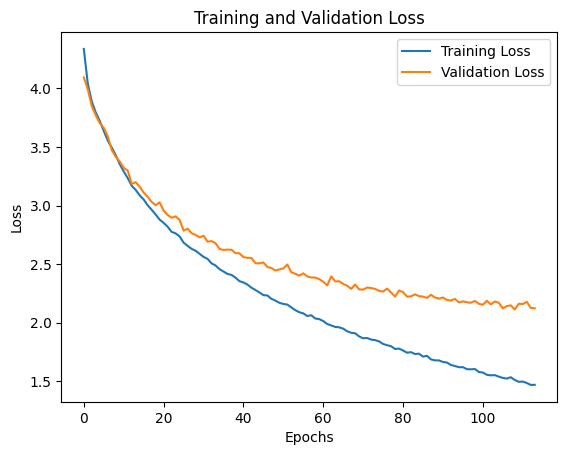

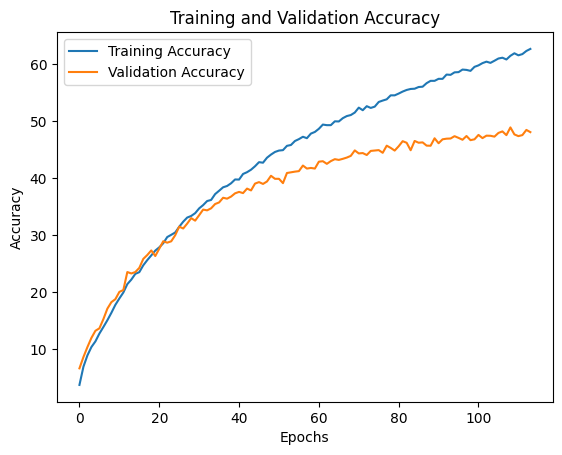

Epoch 1 duration: 0 hours, 3 minutes, 55 seconds
Epoch 2 duration: 0 hours, 3 minutes, 54 seconds
Epoch 3 duration: 0 hours, 3 minutes, 54 seconds
Epoch 4 duration: 0 hours, 3 minutes, 54 seconds
Epoch 5 duration: 0 hours, 3 minutes, 54 seconds
Epoch 6 duration: 0 hours, 3 minutes, 54 seconds
Epoch 7 duration: 0 hours, 3 minutes, 54 seconds
Epoch 8 duration: 0 hours, 3 minutes, 54 seconds
Epoch 9 duration: 0 hours, 3 minutes, 54 seconds
Epoch 10 duration: 0 hours, 3 minutes, 54 seconds
Epoch 11 duration: 0 hours, 3 minutes, 54 seconds
Epoch 12 duration: 0 hours, 3 minutes, 54 seconds
Epoch 13 duration: 0 hours, 3 minutes, 54 seconds
Epoch 14 duration: 0 hours, 3 minutes, 54 seconds
Epoch 15 duration: 0 hours, 3 minutes, 54 seconds
Epoch 16 duration: 0 hours, 3 minutes, 54 seconds
Epoch 17 duration: 0 hours, 3 minutes, 54 seconds
Epoch 18 duration: 0 hours, 3 minutes, 54 seconds
Epoch 19 duration: 0 hours, 3 minutes, 54 seconds
Epoch 20 duration: 0 hours, 3 minutes, 54 seconds
Epoch 21 

In [4]:
# Input jumlah epoch
jumlah_epoch = 300

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = KANVGG19(num_classes=100).to(device)
print(model)
summary(model, input_size=(3, 32, 32))

# DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Function to print model parameter details
def print_parameter_details(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()} {'requires_grad' if param.requires_grad else 'frozen'}")

print_parameter_details(model)

# Define transformations for training and validation data
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val)

# Split training set into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(trainset))), test_size=0.2, stratify=trainset.targets)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Define DataLoaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=val_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=100)

# Training function
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# Validation function
def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Validation Epoch: {epoch} [{batch_idx * len(inputs)}/{len(val_loader.dataset)} ({100. * batch_idx / len(val_loader):.0f}%)]\tLoss: {loss.item():.6f}')

            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    print(classification_report(all_labels, all_predictions))
    return val_loss / len(val_loader), accuracy

# Early stopping
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Timing variables
epoch_times = []
total_start_time = time.time()

# Function to convert seconds to hours, minutes, seconds
def convert_seconds(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return hours, minutes, seconds

for epoch in range(jumlah_epoch):
    epoch_start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device, epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{jumlah_epoch}, Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%")
    scheduler.step(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)
    hours, minutes, seconds = convert_seconds(epoch_duration)
    print(f"Epoch {epoch+1} duration: {hours} hours, {minutes} minutes, {seconds} seconds")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_weights_KAN.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

total_end_time = time.time()
total_duration = total_end_time - total_start_time
total_hours, total_minutes, total_seconds = convert_seconds(total_duration)
print(f"Total training time: {total_hours} hours, {total_minutes} minutes, {total_seconds} seconds")

model.load_state_dict(torch.load('best_model_weights_KAN.pth'))

# Evaluate model on test set
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return accuracy, np.array(all_predictions), np.array(all_labels)

accuracy, preds, true_labels = test(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.2f}%')

# Save predictions and labels for ROC plotting
np.save('preds_cifar100.npy', preds)
np.save('true_labels_cifar100.npy', true_labels)

# Plot training and validation loss
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot training and validation accuracy
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

for i, epoch_time in enumerate(epoch_times):
    hours, minutes, seconds = convert_seconds(epoch_time)
    print(f"Epoch {i+1} duration: {hours} hours, {minutes} minutes, {seconds} seconds")

/tmp/ipykernel_34/1985180903.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20').colors


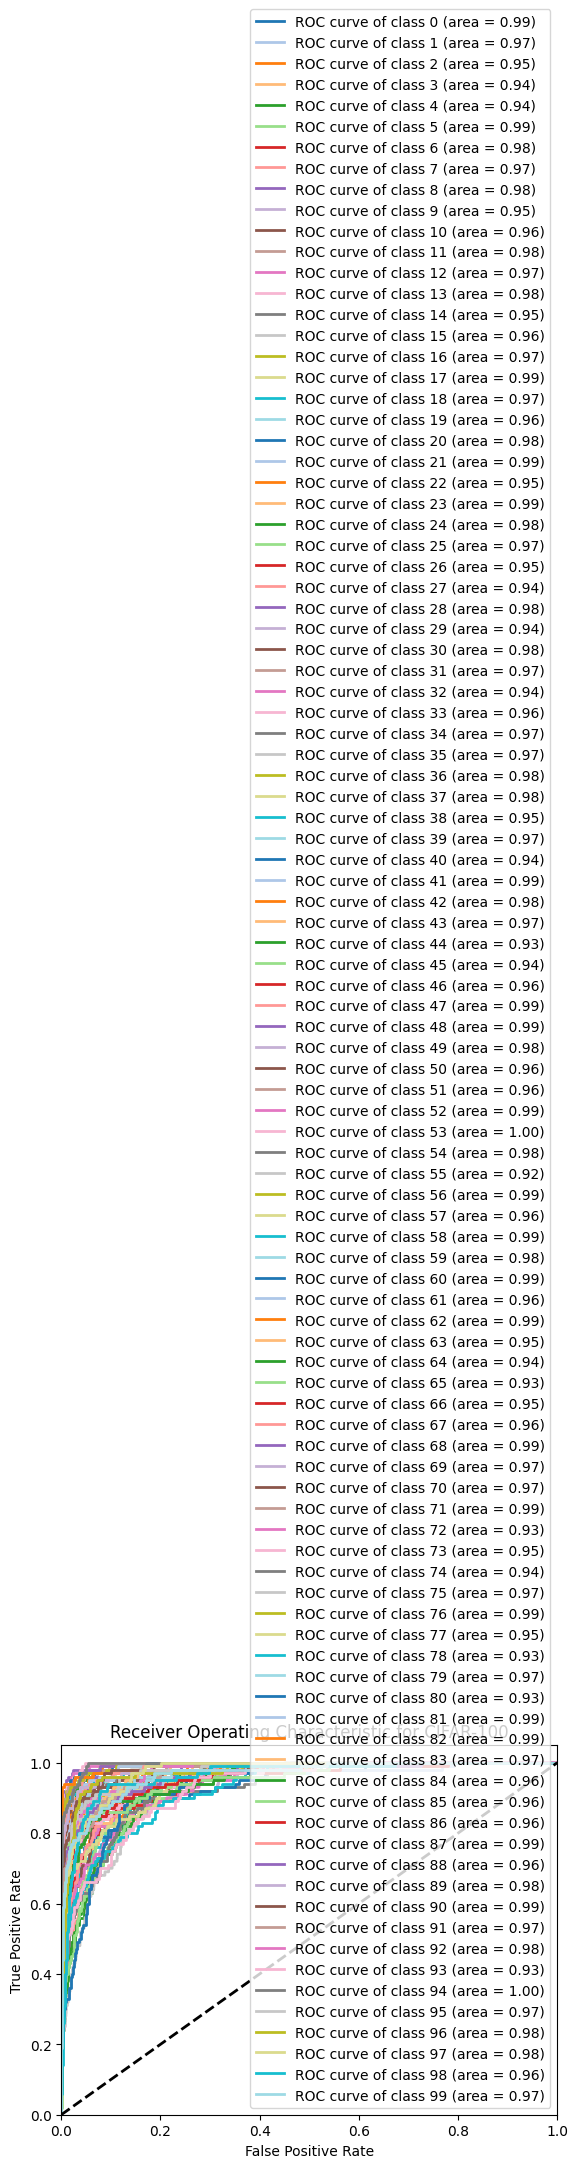

 
Accuracy: 0.5680
Precision: 0.5780
Recall: 0.5680
F1 Score: 0.5680
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.73      0.81       100
     Class 1       0.73      0.65      0.69       100
     Class 2       0.49      0.46      0.47       100
     Class 3       0.41      0.24      0.30       100
     Class 4       0.26      0.26      0.26       100
     Class 5       0.57      0.73      0.64       100
     Class 6       0.67      0.64      0.66       100
     Class 7       0.55      0.63      0.59       100
     Class 8       0.65      0.72      0.69       100
     Class 9       0.76      0.66      0.71       100
    Class 10       0.43      0.44      0.43       100
    Class 11       0.42      0.31      0.36       100
    Class 12       0.63      0.72      0.67       100
    Class 13       0.58      0.43      0.49       100
    Class 14       0.48      0.53      0.50       100
    Class 15       0.46      0.59      0.52

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

# Load predictions and true labels
preds = np.load('preds_cifar100.npy')
true_labels = np.load('true_labels_cifar100.npy')

# Function to plot ROC curve for multi-class classification
def plot_roc_curve(true_labels, preds, n_classes):
    true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = plt.cm.get_cmap('tab20').colors
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i % 20], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for CIFAR-100')
    plt.legend(loc="lower right")
    plt.show()

# Function to calculate and print classification metrics for multi-class classification
def print_classification_metrics(true_labels, preds, n_classes):
    preds_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(true_labels, preds_labels)
    precision = precision_score(true_labels, preds_labels, average='macro')
    recall = recall_score(true_labels, preds_labels, average='macro')
    f1 = f1_score(true_labels, preds_labels, average='macro')
    report = classification_report(true_labels, preds_labels, target_names=[f'Class {i}' for i in range(n_classes)])

    print(" ")
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(report)

# Plot ROC curve and print classification metrics
n_classes = 100
plot_roc_curve(true_labels, preds, n_classes)
print_classification_metrics(true_labels, preds, n_classes)
